When a bank (or another credit institute) receives an application for a loan it must perform a risk assessment in order to evaluate whether or not the applicant is eligible for credit. In the case the specific individual has a good credit risk it is more likely that he or she will repay the debt. Viceversa if an individual has a bad credit risk then there is an highly likelihood that the bank will lose money if it accepts to give a loan to the applicant. In this analysis I will focus on trying to predict the risk score of individuals using socio-economical factors. I will use the <a href="https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29">German Credit Dataset</a> (Statlog), which contains 1000 samples: 20 features and 1 response variable. The features describe the demographic and socio-economical situation of every sample, while the response variable indicates the risk score for the individual using two values: good risk score (numerical value $1$ in the dataset) and bad risk score (numerical value $2$ in the dataset). This problem is then a supervised binary classification problem.

### The dataset

The dataset is composed of both categorical and numerical features which are used to describe the socio-economic situation of the credit applicants, the categorical ones are codified with alpha numerical codes, a feature conversion strategy is needed (more on that later). As an example I report the meaning of some of the features of the dataset

**Existing Checking Account (Qualitative)**

Status of existing checking account i.e. range of money in existing checking account (if present)

| Value | Description|
| --- | --- |
| A11 | .. < 0 DM | 
| A12 | 0 <= ... < 200 DM | 
| A13 | ... >= 200 DM / salary assignments for at least 1 year |
| A14 | no checking account|

Note: DM stands for Deutsche Marks.

**Month Duration (Numerical)**

Duration in month of the asked loan

**Purpose (Qualitative)**

Purpose of the requested loan

| Value | Description|
| --- | --- |
| A40 | car (new)
| A41 | car (used)
| A42 | furniture/equipment
| A43 | radio/television
| A44 | domestic appliances
| A45 | repairs
| A46 | education
| A47 | vacation
| A48 | retraining
| A49 | business
| A410 | others

**Credit Amount (Numerical)**

Amount of money requested for the credit

**Personal Status and Sex (Qualitative)**

| Value | Description|
| --- | --- |
|A91 | male : divorced/separated
|A92 | female : divorced/separated/married
|A93 | male : single
|A94 | male : married/widowed
|A95 | female : single

**Property (Qualitative)**

Type of property owned by the applicant

| Value | Description|
| --- | --- |
|A121 | real estate
|A122 | if not A121 : building society savings agreement/ life insurance
|A123 | if not A121/A122 : car or other, not in attribute 6
|A124 | unknown / no property

**Age (Numerical)**

Age in years

**Housing (Qualitative)**

| Value | Description|
| --- | --- |
|A151 | rent
|A152 | own
|A153 | for free

**Existing credit number (Numerical)**

Number of existing credit at this bank

**Result (Response)**

| Value | Description|
| --- | --- |
|1 | good (applicant eligible for credit)
|2 | bad (applicant not eligible for credit)

As we can see the value used for describing the response are $1 \implies good$ result and $2 \implies bad$ result. We will say in the rest of the work that a negative result means a good risk score (eligibility) while a positive result to a bad score (no eligibility). Further in the classification pipeline we will change the numerical labels of the response in order to have values of $0 \implies \text{negative (good risk)}$ and $1 \implies \text{positive (bad risk)}$.

### Loading packages

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import sklearn
import sys

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import f1_score, fbeta_score, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import StratifiedKFold

from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import ADASYN, SMOTE


from pandas.api.types import is_numeric_dtype

palette = ["#9b59b6", "#5497db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(palette)


### Data exploration

We will now explore the data in order to understand it and find some patterns. Let's start by loading the german.data file into a Pandas DataFrame

In [2]:
# Columns of the dataset (data comes without an header)
columns = ["existing_account", "month_duration", "credit_history",\
           "purpose", "credit_amount", "saving_bonds",\
           "employment_status", "installment_rate", "status_sex", \
           "debts_status", "resident_since", "property", \
           "age", "installment_plans", "housing_status", \
           "credit_number", "job", "people_liability", \
           "telephone", "foreign", "result"]

numerical_attributes = ["month_duration", "credit_amount", "installment_rate", "resident_since", "age",\
                        "credit_number", "people_liability"]

In [3]:
df = pd.read_csv("german.data", sep=" ", header=None, names=columns)

We can inspect some of the first rows of the DataFrame using the head method of Pandas

In [4]:
df.head()

,existing_account,month_duration,credit_history,purpose,credit_amount,saving_bonds,employment_status,installment_rate,status_sex,debts_status,...,property,age,installment_plans,housing_status,credit_number,job,people_liability,telephone,foreign,result
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


With df.info() we can find if some data are missing

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   existing_account   1000 non-null   object
 1   month_duration     1000 non-null   int64 
 2   credit_history     1000 non-null   object
 3   purpose            1000 non-null   object
 4   credit_amount      1000 non-null   int64 
 5   saving_bonds       1000 non-null   object
 6   employment_status  1000 non-null   object
 7   installment_rate   1000 non-null   int64 
 8   status_sex         1000 non-null   object
 9   debts_status       1000 non-null   object
 10  resident_since     1000 non-null   int64 
 11  property           1000 non-null   object
 12  age                1000 non-null   int64 
 13  installment_plans  1000 non-null   object
 14  housing_status     1000 non-null   object
 15  credit_number      1000 non-null   int64 
 16  job                1000 non-null   object
 

With the describe method we can see some basics statistics about the quantitative features

In [6]:
df.describe()

,month_duration,credit_amount,installment_rate,resident_since,age,credit_number,people_liability,result
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,1.300000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.458487
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,2.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,2.000000


We will now check the class distribution in the dataset to see whether there is some imbalance

In [7]:

# Positive labels
eligible= df["result"] == 1
print(f"The proportion of individuals which are eligible for credit (good risk) is: {df[eligible].shape[0]/df.shape[0]}")

# Negative labels
not_eligible= df["result"] == 2
print(f"The proportion of individuals which are not eligible for credit (bad risk) is: {df[not_eligible].shape[0]/df.shape[0]}")

# We can note a sligthly umbalance

The proportion of individuals which are eligible for credit (good risk) is: 0.7
The proportion of individuals which are not eligible for credit (bad risk) is: 0.3


As we can see from the cell above the dataset is unbalanced, in fact the $70\%$ of observation belong to the negative class while only the $30\%$ to the positive one. This is not an high imbalance but should be considered. We will use some oversampling methods in the next section in order to cope with this problem

#### Label encoding

We are dealing with a mixed dataset in which there are qualitative and quantitative variables. In order to fed the data to a machine learning algorithm we need to convert the categorical features in numerical one. This is done via label encoding. In this work I used the dummy encoding technique.

#### Dummy Encoding

When there is not a clear ordinal relationship between the categories we can apply a dummy encoding strategy. Given one categorical variables with $k$ categories, a dummy encoder creates $k-1$ binary values which assume the value $1$ if the object belong to that category, $0$ otherwise. We will now perform dummy encoding on the categorical variables.

In [8]:
df_numerical = df.copy()

dummy_columns = ["credit_history", "purpose", "status_sex", "debts_status", "property", "installment_plans", "housing_status", \
            "foreign", "existing_account", "saving_bonds", "telephone", "job", "employment_status"]

df_numerical = pd.get_dummies(df_numerical, columns=dummy_columns, drop_first=True)

In [9]:
df_numerical.head()

,month_duration,credit_amount,installment_rate,resident_since,age,credit_number,people_liability,result,credit_history_A31,credit_history_A32,...,saving_bonds_A64,saving_bonds_A65,telephone_A192,job_A172,job_A173,job_A174,employment_status_A72,employment_status_A73,employment_status_A74,employment_status_A75
0,6,1169,4,4,67,2,1,1,0,0,...,0,1,1,0,1,0,0,0,0,1
1,48,5951,2,2,22,1,1,2,0,1,...,0,0,0,0,1,0,0,1,0,0
2,12,2096,2,3,49,1,2,1,0,0,...,0,0,0,1,0,0,0,0,1,0
3,42,7882,2,4,45,1,2,1,0,1,...,0,0,0,0,1,0,0,0,1,0
4,24,4870,3,4,53,2,2,2,0,0,...,0,0,0,0,1,0,0,1,0,0


After the label encoding we end up with $49$ columns instead of the original $21$ (so there are $48$ features).

#### Correlation analysis

We will now plot the correlation matrix between the numerical variables in order to check whether there are some higly correlated features. The idea here is that if two features are highly correlated this might imply that one variables is described by the other, so one of the two correlated variables could be discarded simplifying the problem.

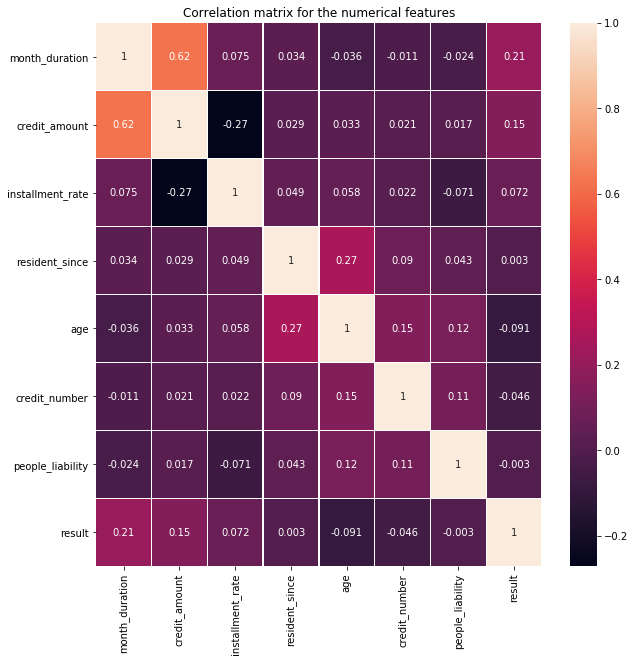

In [10]:
corr = df.corr()

fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.heatmap(corr, annot=True, linewidth=0.5, xticklabels=numerical_attributes + ["result"])
ax.set_yticklabels(labels=numerical_attributes + ["result"], rotation=0)
ax.set_title("Correlation matrix for the numerical features")
plt.show()

As we can see there is not an high correlation between the numerical features, the highest value of correlation is between the variables credit amount and month duration, but these can be simply explained saying that it is natural that loans with an higher price will have an higher duration in month. However this relation is not so prevalent as we will see in the scatterplot between these two variables.

Now we can look at the correlation matrix considering also the dummy encoded variables

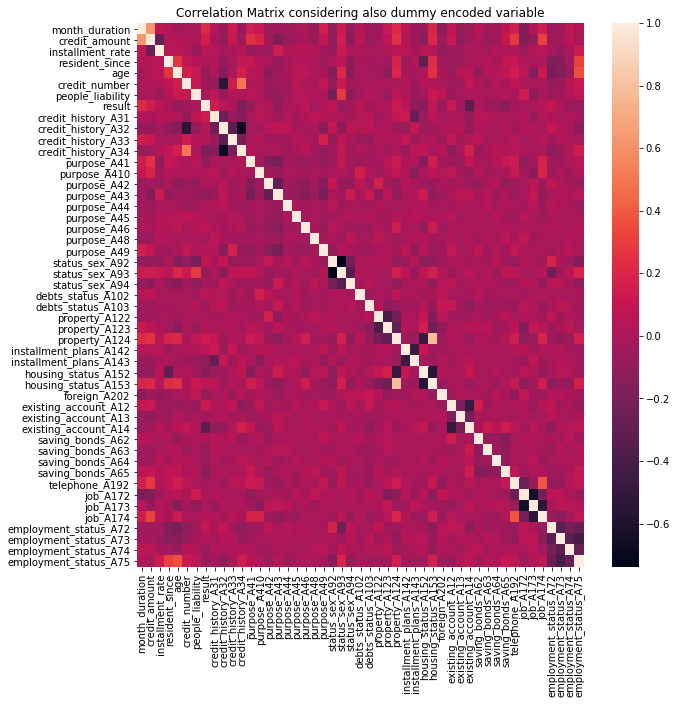

In [11]:
corr = df_numerical.corr()

fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.heatmap(corr, xticklabels=corr.columns)
ax.set_yticklabels(labels=corr.columns, rotation=0) 
ax.set_title("Correlation Matrix considering also dummy encoded variable")
plt.show()

Unfortunately this matrix is not so interpretable like the one with only the quantitative variables, for this reason the couples of variables with highest absolute correlation have been reported here.

In [12]:
corr_unstacked = corr.unstack().abs()
ranked_corr = corr_unstacked.sort_values(kind="quicksort", ascending=False)
ranked_corr = ranked_corr[ranked_corr != 1]

ranked_corr.head(10)

property_A124        housing_status_A153    0.779853
housing_status_A153  property_A124          0.779853
status_sex_A92       status_sex_A93         0.738036
status_sex_A93       status_sex_A92         0.738036
credit_history_A32   credit_history_A34     0.683617
credit_history_A34   credit_history_A32     0.683617
job_A172             job_A173               0.652438
job_A173             job_A172               0.652438
month_duration       credit_amount          0.624984
credit_amount        month_duration         0.624984
dtype: float64

As we can see the highest value of correlation between two dummy encoded variables is of $0.78$. The variable housing_status_153 assumes value $1$ when the applicant lives for free at the expenses of another person, while the variable property_A124 assumes value $1$ when the individual does not own a property. So this correlation value is quite explicable.

A common threshold used in machine learning for eliminating variables due to high correlations is $0.85$, this threshold is quite arbitrary and can be problem dependent. In this situation I decided to leave both the variables (we will use PCA in order to get uncorrelated features).

#### Pairplots

A beatiful way to look at the relationships between the numerical variables is through pairplots. On the diagonal we can see the normalized histograms with the distribution of the quantitative features, while on the other cells we can see the scatter plot of one numerical variable against another one.

Text(0.5, 1.08, 'Pairplots for the numberical variables')

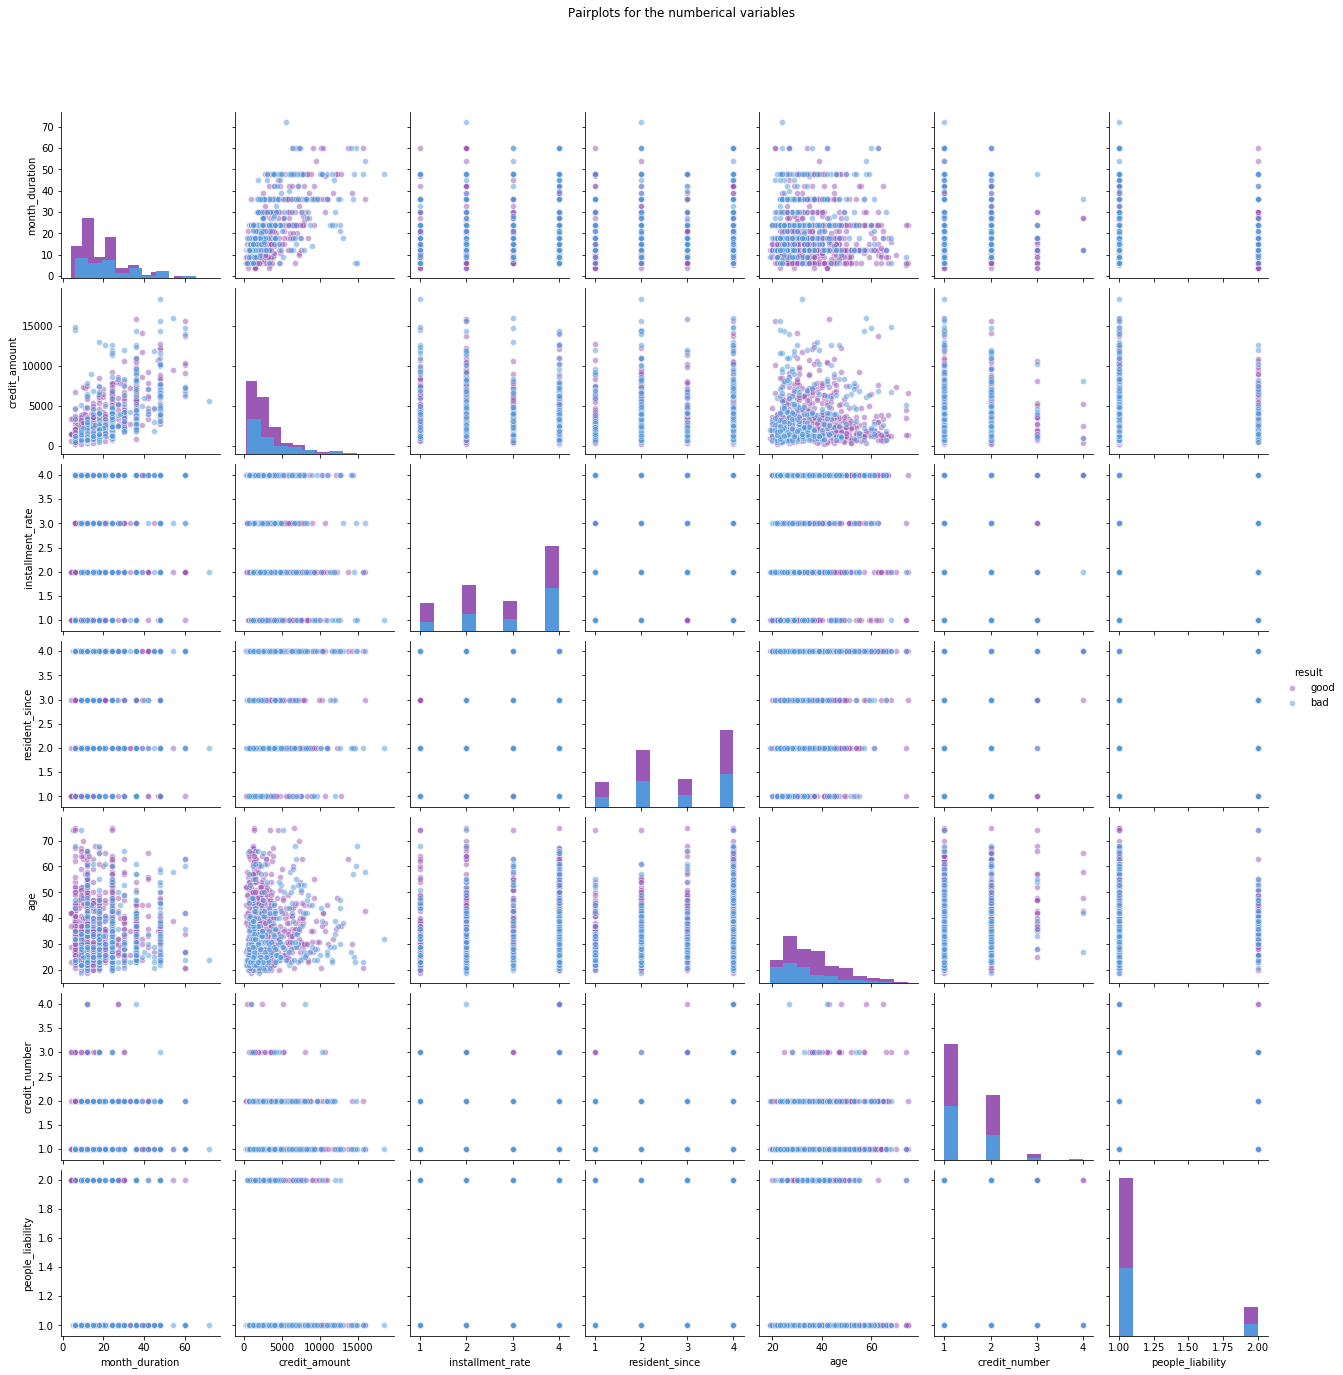

In [13]:
pairplot_df = df.loc[:, numerical_attributes + ["result"]].replace({"result": {1:"good", 2:"bad"}})
ax = sns.pairplot(pairplot_df, hue="result", plot_kws={"alpha":0.5}, diag_kind="hist")
ax.fig.suptitle("Pairplots for the numberical variables", y=1.08)

The distributions of the quantitative variables are quite different from each other. For example the distribution of the age seems a bit skewed to the left and assumes its maximum around the age of $35$ years. The variable credit amount on the other hand decreases as the amount requested increases. Other variables, like for example people_liability or resident_since assume only a limited number of values in the plot.
By looking at the scatter plot between credit_amount and month_duration we can see a mild linear relationships. This was already spotted in the correlation value of $0.62$ found in the previous section between these two variables.

#### Contingency Tables

We will now use some contingency tables to see if there are relationships between two categorical variables or between one categorical variable and the response. I have reported here only some of the most important

In [14]:
# Utility function that given the dataset prints a table pivoted for two values of interest with the counts of each one
def entries_per_couple_variables(df, first_var, second_var, first_level_indexes=None, second_level_indexes=None):
    # perform the renaming on the column values
    renamed_df = df.loc[:,[first_var, second_var]]
    if first_level_indexes is not None and second_level_indexes is not None:
        renamed_df = renamed_df.replace({first_var:first_level_indexes, second_var:second_level_indexes})
    # group for the two columns
    grouped_df = renamed_df.groupby([first_var, second_var]).size().reset_index()
    
    # pivot the result

    pivoted_df = pd.pivot_table(grouped_df, index=first_var, columns=second_var, values=0)
    pivoted_df["Total Column Sum"] = pivoted_df.sum(axis=1)
    for index in second_level_indexes.values():
        pivoted_df[f"proportion_{index}"] = pivoted_df[index]/pivoted_df["Total Column Sum"]
    
    df_total_rows = pivoted_df.sum(axis=0)
    df_total_rows = df_total_rows.rename("Total Row Sum")
    
    
    pivoted_df = pivoted_df.append(df_total_rows)
    for index in first_level_indexes.values():
        prop_df = pivoted_df.loc[index]/df_total_rows
        prop_df = prop_df.rename(f"proportion_{index}")
        prop_df[len(second_level_indexes):] = "-"
        pivoted_df = pivoted_df.append(prop_df)
            
    df_total_rows[len(second_level_indexes)+1:] = "-"
    pivoted_df.loc["Total Row Sum"] = df_total_rows
    
    return pivoted_df

In [15]:
saving_bonds_level_indexes = {"A61": "A61: < 100DM",
                       "A62":"A62: 100 DM<=...< 500DM",
                       "A63":"A63: 500 DM <= ... < 1000 DM",
                       "A64":"A64: >= 1000 DM",
                       "A65":"A65: unknown/ no savings account"}
second_level_indexes = {1:"good", 2:"bad"}
entries_per_couple_variables(df, "saving_bonds", "result", saving_bonds_level_indexes, second_level_indexes)

result,bad,good,Total Column Sum,proportion_good,proportion_bad
saving_bonds,,,,,
A61: < 100DM,217.000000,386.000000,603,0.640133,0.359867
A62: 100 DM<=...< 500DM,34.000000,69.000000,103,0.669903,0.330097
A63: 500 DM <= ... < 1000 DM,11.000000,52.000000,63,0.825397,0.174603
A64: >= 1000 DM,6.000000,42.000000,48,0.875,0.125
A65: unknown/ no savings account,32.000000,151.000000,183,0.825137,0.174863
Total Row Sum,300.000000,700.000000,1000,-,-
proportion_A61: < 100DM,0.723333,0.551429,-,-,-
proportion_A62: 100 DM<=...< 500DM,0.113333,0.098571,-,-,-
proportion_A63: 500 DM <= ... < 1000 DM,0.036667,0.074286,-,-,-


In [16]:
existing_account_level_indexes = {"A11": "A11: .. < 0 DM",
                       "A12": "A12: 0 <= ... < 200 DM",
                       "A13": "A13: ... >= 200 DM / salary assignments for at least 1 year",
                       "A14": "A14: no checking account"}

entries_per_couple_variables(df, "existing_account", "result", existing_account_level_indexes, second_level_indexes)

result,bad,good,Total Column Sum,proportion_good,proportion_bad
existing_account,,,,,
A11: .. < 0 DM,135.000000,139.000000,274,0.507299,0.492701
A12: 0 <= ... < 200 DM,105.000000,164.000000,269,0.609665,0.390335
A13: ... >= 200 DM / salary assignments for at least 1 year,14.000000,49.000000,63,0.777778,0.222222
A14: no checking account,46.000000,348.000000,394,0.883249,0.116751
Total Row Sum,300.000000,700.000000,1000,-,-
proportion_A11: .. < 0 DM,0.450000,0.198571,-,-,-
proportion_A12: 0 <= ... < 200 DM,0.350000,0.234286,-,-,-
proportion_A13: ... >= 200 DM / salary assignments for at least 1 year,0.046667,0.070000,-,-,-
proportion_A14: no checking account,0.153333,0.497143,-,-,-


In [17]:
entries_per_couple_variables(df, "existing_account", "saving_bonds", existing_account_level_indexes, saving_bonds_level_indexes)

saving_bonds,A61: < 100DM,A62: 100 DM<=...< 500DM,A63: 500 DM <= ... < 1000 DM,A64: >= 1000 DM,A65: unknown/ no savings account,Total Column Sum,proportion_A61: < 100DM,proportion_A62: 100 DM<=...< 500DM,proportion_A63: 500 DM <= ... < 1000 DM,proportion_A64: >= 1000 DM,proportion_A65: unknown/ no savings account
existing_account,,,,,,,,,,,
A11: .. < 0 DM,219.000000,12.000000,8.000000,6.000000,29.000000,274,0.79927,0.0437956,0.0291971,0.0218978,0.105839
A12: 0 <= ... < 200 DM,152.000000,47.000000,11.000000,14.000000,45.000000,269,0.565056,0.174721,0.0408922,0.0520446,0.167286
A13: ... >= 200 DM / salary assignments for at least 1 year,41.000000,5.000000,4.000000,3.000000,10.000000,63,0.650794,0.0793651,0.0634921,0.047619,0.15873
A14: no checking account,191.000000,39.000000,40.000000,25.000000,99.000000,394,0.484772,0.0989848,0.101523,0.0634518,0.251269
Total Row Sum,603.000000,103.000000,63.000000,48.000000,183.000000,1000,-,-,-,-,-
proportion_A11: .. < 0 DM,0.363184,0.116505,0.126984,0.125000,0.158470,-,-,-,-,-,-
proportion_A12: 0 <= ... < 200 DM,0.252073,0.456311,0.174603,0.291667,0.245902,-,-,-,-,-,-
proportion_A13: ... >= 200 DM / salary assignments for at least 1 year,0.067993,0.048544,0.063492,0.062500,0.054645,-,-,-,-,-,-
proportion_A14: no checking account,0.316750,0.378641,0.634921,0.520833,0.540984,-,-,-,-,-,-


In [18]:
housing_level_indexes = {"A151":"A151: rent",\
                       "A152":"A152: own", \
                       "A153":"A153: for free"}
entries_per_couple_variables(df, "housing_status", "result", housing_level_indexes, second_level_indexes)

result,bad,good,Total Column Sum,proportion_good,proportion_bad
housing_status,,,,,
A151: rent,70.000000,109.000000,179,0.608939,0.391061
A152: own,186.000000,527.000000,713,0.73913,0.26087
A153: for free,44.000000,64.000000,108,0.592593,0.407407
Total Row Sum,300.000000,700.000000,1000,-,-
proportion_A151: rent,0.233333,0.155714,-,-,-
proportion_A152: own,0.620000,0.752857,-,-,-
proportion_A153: for free,0.146667,0.091429,-,-,-


In [19]:
property_level_indexes = {"A121": "A121: real estate",\
                          "A122": "A122: if not A121 : building society savings agreement/ life insurance",\
                          "A123": "A123: if not A121/A122 : car or other, not in attribute 6",\
                          "A124": "A124: unknown / no property"}

entries_per_couple_variables(df, "housing_status", "property", housing_level_indexes, property_level_indexes)

property,A121: real estate,A122: if not A121 : building society savings agreement/ life insurance,"A123: if not A121/A122 : car or other, not in attribute 6",A124: unknown / no property,Total Column Sum,proportion_A121: real estate,proportion_A122: if not A121 : building society savings agreement/ life insurance,"proportion_A123: if not A121/A122 : car or other, not in attribute 6",proportion_A124: unknown / no property
housing_status,,,,,,,,,
A151: rent,55.000000,46.000000,60.000000,18.000000,179,0.307263,0.256983,0.335196,0.100559
A152: own,226.000000,184.000000,271.000000,32.000000,713,0.316971,0.258065,0.380084,0.0448808
A153: for free,1.000000,2.000000,1.000000,104.000000,108,0.00925926,0.0185185,0.00925926,0.962963
Total Row Sum,282.000000,232.000000,332.000000,154.000000,1000,-,-,-,-
proportion_A151: rent,0.195035,0.198276,0.180723,0.116883,-,-,-,-,-
proportion_A152: own,0.801418,0.793103,0.816265,0.207792,-,-,-,-,-
proportion_A153: for free,0.003546,0.008621,0.003012,0.675325,-,-,-,-,-


In [20]:
first_level_indexes = {"A91":"A91: male:divorced/separated",\
                       "A92":"A92: female:divorced/separated/married",\
                       "A93":"A93: male:single",\
                       "A94":"A94: male:married/widowed"}
entries_per_couple_variables(df, "status_sex", "result", first_level_indexes, second_level_indexes)

result,bad,good,Total Column Sum,proportion_good,proportion_bad
status_sex,,,,,
A91: male:divorced/separated,20.000000,30.000000,50,0.6,0.4
A92: female:divorced/separated/married,109.000000,201.000000,310,0.648387,0.351613
A93: male:single,146.000000,402.000000,548,0.733577,0.266423
A94: male:married/widowed,25.000000,67.000000,92,0.728261,0.271739
Total Row Sum,300.000000,700.000000,1000,-,-
proportion_A91: male:divorced/separated,0.066667,0.042857,-,-,-
proportion_A92: female:divorced/separated/married,0.363333,0.287143,-,-,-
proportion_A93: male:single,0.486667,0.574286,-,-,-
proportion_A94: male:married/widowed,0.083333,0.095714,-,-,-


In [21]:
first_level_indexes = {"A40":"A40: car (new)",\
                       "A41":"A41: car (used)",\
                       "A42":"A42: furniture/equipment",\
                       "A43":"A43: radio/television",\
                       "A44":"A44: domestic appliances",\
                       "A45":"A45: repairs",\
                       "A46":"A46: education",\
                       "A48" : "A48: retraining",\
                       "A49":"A49: business",\
                       "A410" : "A410: others"}
entries_per_couple_variables(df, "purpose", "result", first_level_indexes, second_level_indexes)

result,bad,good,Total Column Sum,proportion_good,proportion_bad
purpose,,,,,
A40: car (new),89.000000,145.000000,234,0.619658,0.380342
A410: others,5.000000,7.000000,12,0.583333,0.416667
A41: car (used),17.000000,86.000000,103,0.834951,0.165049
A42: furniture/equipment,58.000000,123.000000,181,0.679558,0.320442
A43: radio/television,62.000000,218.000000,280,0.778571,0.221429
A44: domestic appliances,4.000000,8.000000,12,0.666667,0.333333
A45: repairs,8.000000,14.000000,22,0.636364,0.363636
A46: education,22.000000,28.000000,50,0.56,0.44
A48: retraining,1.000000,8.000000,9,0.888889,0.111111


In [22]:
job_level_indexes = {"A171": "unemployed/ unskilled - non-resident",\
                     "A172": "A172: unskilled - resident",\
                     "A173": "A173: skilled employee / official",\
                     "A174": "A174: management/ self-employed/highly qualified employee/ officer"}
entries_per_couple_variables(df, "job", "result", job_level_indexes, second_level_indexes)

result,bad,good,Total Column Sum,proportion_good,proportion_bad
job,,,,,
A172: unskilled - resident,56.000000,144.000000,200,0.72,0.28
A173: skilled employee / official,186.000000,444.000000,630,0.704762,0.295238
A174: management/ self-employed/highly qualified employee/ officer,51.000000,97.000000,148,0.655405,0.344595
unemployed/ unskilled - non-resident,7.000000,15.000000,22,0.681818,0.318182
Total Row Sum,300.000000,700.000000,1000,-,-
proportion_unemployed/ unskilled - non-resident,0.023333,0.021429,-,-,-
proportion_A172: unskilled - resident,0.186667,0.205714,-,-,-
proportion_A173: skilled employee / official,0.620000,0.634286,-,-,-
proportion_A174: management/ self-employed/highly qualified employee/ officer,0.170000,0.138571,-,-,-


#### Boxplots

Boxplots are a great tool for exploring the data distrubution and look for outliers. With boxplots we can summarize the data distributions in a nice visualization. We have that the lower part of the wisker is the minumum computed considering the interquartile range: $Q1-1.5\times IQR$, where $Q1$ is the first quartile ($25\%$ percentile) and $IQR$ is the interquartile range, which is the difference between $Q3$ ($3$rd quartile) and $Q1$. The lower edge of the rectangle is $Q1$ while the line in the middle is the median $Q2$; the upper edge of the box is $Q3$. The upper whisker is the maximum computed considering $Q3+1.5\times IQR$. The points that are outside the whiskers are labeled as outliers. The green triangle in the plot indicates the mean of the distribution.

<figure>
<img src="media/box_plot.png" style="width: 400px;">
    <figcaption><center><i>Boxplot Legend. <a href="https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51">Source</a></i></center></figcaption>
</figure>

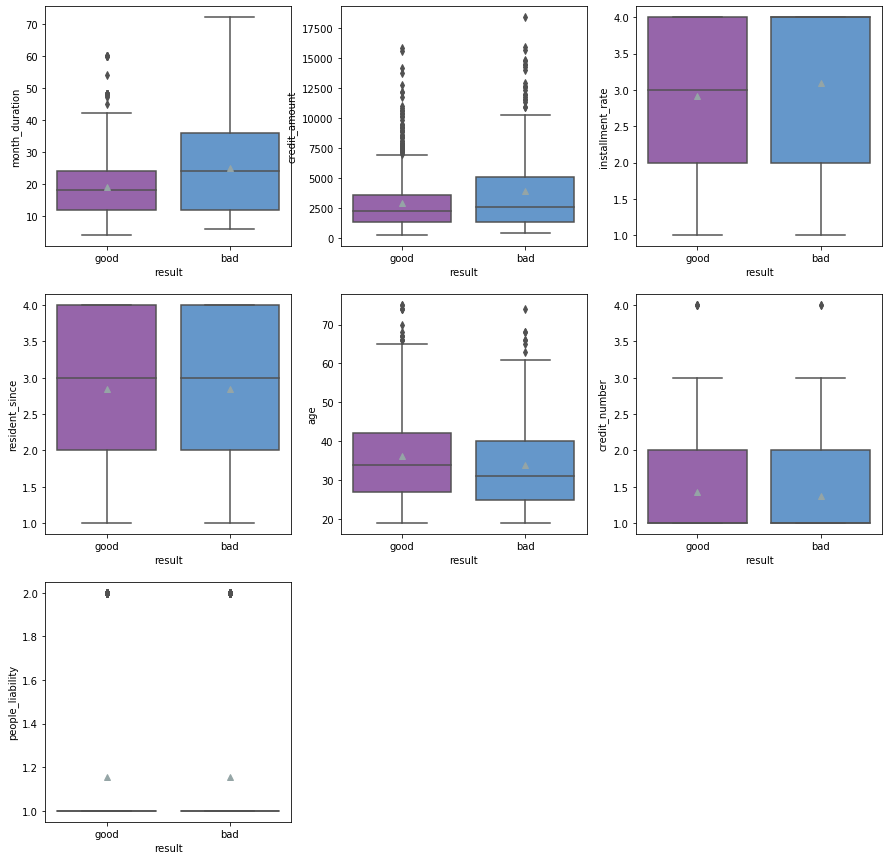

In [23]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

i = 0
j = 0

for category in numerical_attributes:
    sns.boxplot(y=df[category], x=df["result"].replace({1:"good", 2:"bad"}), ax=axs[i, j], orient="v", showmeans=True)
    j += 1
    if j%3 == 0:
        j = 0
        i += 1
        
axs[2, 1].set_visible(True)
fig.delaxes(axs[2, 1])
axs[2, 2].set_visible(True)
fig.delaxes(axs[2, 2])

As we can see the boxplot reveals some outliers, but they are not wrong or out of scale values so the decision to keep them has been made

### Data Preprocessing

#### Train-test split

We will now divide our dataset into a training part and a test part. The training set will be fed to the cross validation for tuning the model, while the test set is used to test the performance of our model (hyperparameter tuning is not done on the test set of course). The training set contains the $70\%$ of the original observations, while the test set the $30\%$. The split is done in a stratified way, this means that the we keep the label distribution between the sets.

In [24]:
X = np.array(df_numerical.loc[:, df_numerical.columns != "result"])
print(f"Shape of the features of the dataset: {X.shape}")

y = np.array(df_numerical.loc[:, "result"].replace({1:0, 2:1}))
print(f"Shape of the labels of the dataset: {y.shape}")

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3, stratify=y)

print(f"Shape of the training set: {X_train.shape}")
print(f"Shape of the test set: {X_test.shape}")

Shape of the features of the dataset: (1000, 48)
Shape of the labels of the dataset: (1000,)
Shape of the training set: (700, 48)
Shape of the test set: (300, 48)


#### Data Standardization

As a preprocessing step is important to normalize the data. This is useful to bring all the features on the same scale. Most of the machine learning algorithm work better for normalized data. There are various tecnique for normalization, like for example min-max normalization or standardization. Here I have decided to adopt the latter. With the operation of data standardization we want each feature to have mean zero and variance one, this is done by subtracting from each column of the dataset the mean and dividing by the column variance. In mathematical formulas:

$x_{i, standardized} = \frac{x_i-\bar{x}}{\hat{\sigma_{x}}}$

This operation is done for every column of the dataset.

In [25]:
# Standardize data
scaler = StandardScaler()
X_train_raw = X_train
X_test_raw = X_test

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Oversampling and Undersampling

The German Credit Dataset as we saw is slightly imbalanced. A situation in which one class is represented at the $70\%$ and the other at the $30\%$ is not a bad imbalance and most of the algorithms available can deal with this situation. However it could be interesting in this situation to try some tecniques to re-balance the dataset and see if this improves the performances compared to algorithms trained with the original dataset. When dealing with umbalanced data there are mainly two strategies that can be adopted to re-balance it: undersampling and oversampling. Undersampling consists in down-sampling the most rapresented class in order to re-balance the data. In this case the dataset we are using is not so big ($1000$ instances) so there could be the risk that with undersampling some useful information is lost. The other strategy is oversampling, which consists in copying the observations of the under represented class until the dataset is balanced. This of course can cause major overfitting problems.

<figure>
<img src="media/over_under_sampling.png" style="width: 400px;">
    <figcaption><center><i>Oversampling and Undersampling. <a href="https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets#t1">Source</a></i></center></figcaption>
</figure>

A solution to the mentioned problem of oversampling is creating new synthetic observations for the under-represented class in order to balance the data. This is the strategy we are going to follow, with ADASYN (Adaptive Synthetic sampling approach for imbalanced learning).
It is important to point out that every oversampling (but also undersampling) technique must be applied only on training data, not on the data used for validation or testing, that's because we want to keep our validation and test set the most similar as possible to the underlying data distribution in order to get accurate results.

#### ADASYN

As we have already said ADASYN will generate some synthetic samples from the under represented class in order to re-balance the dataset. First of all we must define the ratio of majority to minority examples $d$:
\begin{equation*}
d=\frac{m_s}{m_l}
\end{equation*}
where $m_s$ and $m_l$ are respectively the number of majority and minority class examples. If there is an umbalance we can proceed with the algorithm.
Then we can compute the number of samples that must be generated $G$ with:
\begin{equation*}
G=(m_s-m_l)\beta
\end{equation*}
$\beta$ here is the ratio of majority/minority, $\beta=1$ means a perfect balanced dataset after ADASYN.

The next step consists in finding the $k$-Nearest Neighbors of each minority sample ($k$ of course is an hyperparameter to be tuned, default value is $5$). This implies defining a distance, the Euclidean one is used most of the times. 
For each minority point in the feature space then we must compute the number $r_i$:
\begin{equation*}
r_i=\frac{m_{ns,i}}{k}
\end{equation*}
where $m_{ns,i}$ indicates the number of majority points in the neighborhood of the $i$-th minority point.
$r_i$ indicates the dominance of the majority class in the neighborhood.
Now we can normalize the $r_i$'s so that they sum to one:
\begin{equation*}
\hat{r}_i = \frac{r_i}{\sum_ir_i}
\end{equation*}

Then for each neighborhood we calculate the amount $G_i$ of synthetic samples to generate:
\begin{equation*}
G_i=G\hat{r}_i
\end{equation*}

The number of syntetic samples per neighborhood is higher in the neighborhoods in which there is a stronger prevalence of the majority class. This explains the word Adaptive in ADASYN: we generate more samples in the neighborhoods which are harder to learn, because it is more difficult to discriminate the data here. In this way we are making the problem more difficult and we hope that this will give a more robust model.

Having defined the number of samples to generate per neighborhood we can generate $G_i$ samples for each neighborhood. This is done firstly by taking a minority point in the neighborhood $x_i$, secondly by taking another point in the same neighborhood $x_{zi}$, then generating a new synthetic example $s_i$ with the formula:
\begin{equation*}
s_i=x_i+\lambda(x_i-x_{zi})
\end{equation*}
$\lambda$ is a random number between $0$ and $1$.

Visually this consists in generating synthetic points on the line which connects the minority samples.
<figure>
<img src="media/synthetic.png" syle= "width: 200px;">
    <figcaption><center><i>Synthetic points generation. <a href="https://www.datasciencecentral.com/profiles/blogs/handling-imbalanced-data-sets-in-supervised-learning-using-family">Source</a></i></center></figcaption>
</figure>

Some white gaussian noise can be added in order to make new data more realistic.

This method is very useful, but has some drawbacks, in particular:
- There can be neighborhoods with only $1$ minority example. The problem can be solved by copying the minority sample $G_i$ times or simply ignoring such neighborhoods.</il>
- In the case a lot of data is generated in neighborhoods where the density of majority samples is high the synthetic samples could be too similar to the majority one, this could generate a lot of false positives or false negatives.


We are going to apply ADASYN to our training set with $k=5$ and $\beta=1$

In [26]:
# Default beta=1 and default k=5
ada = ADASYN()

X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)

In [27]:
print(f"Shape of the balanced ADASYN dataset is: {X_train_ada.shape}")

pos_ratio = y_train_ada[y_train_ada==1].shape[0]/y_train_ada.shape[0]
neg_ratio = y_train_ada[y_train_ada==0].shape[0]/y_train_ada.shape[0]

print(f"Proportion of positive samples in the balanced training set: {pos_ratio:.2f}")
print(f"Proportion of negative samples in the balanced training set: {neg_ratio:.2f}")

pos_ratio_test = y_test[y_test==1].shape[0]/y_test.shape[0]
neg_ratio_test = y_test[y_test==0].shape[0]/y_test.shape[0]

print(f"Proportion of positive samples in the test set: {pos_ratio_test}")
print(f"Proportion of negative samples in the test set: {neg_ratio_test}")

Shape of the balanced ADASYN dataset is: (949, 48)
Proportion of positive samples in the balanced training set: 0.48
Proportion of negative samples in the balanced training set: 0.52
Proportion of positive samples in the test set: 0.3
Proportion of negative samples in the test set: 0.7


#### SMOTEENN

We said earlier that undersampling may not be the best solution in such a small dataset, but what if we apply first an oversampling tecnique and then an undersampling one? This is what SMOTEENN does: it applies first the SMOTE oversampling algorithm on the minority class to balance the dataset, then the ENN algorithm is applied, this is an undersampling algorithm which has the goal of cleaning the dataset from the misleading examples.

**SMOTE**

The Synthetic Minority Over-sampling Technique (SMOTE) is an algorithm very similar to ADASYN, in fact we could say that ADASYN is a generalization of SMOTE. The only difference is that with SMOTE the number of synthetic samples generated is the same for each neighborhood. The synthetic generation process is exactly the same as in ADASYN

**ENN**

The Edited Nearest Neighbors (ENN) on the other hand is a undersampling tecnique, it works by computing for each point of the class in exam its $k$-nearest neighbors (typically $k=3$), the point considered is removed if the number of neighbors of the other classes is higher than the number of neighbors belonging to the point's class. In other words the point is removed if the sample is misclassified by the $k$-NN algorithm in the dataset. This helps to remove noisy and borderline examples; the idea is to facilitate the learning of the algorithm. The problem here is that the discarded data can have some useful information. Interestingly ENN can be used both in in the majority class and in the minority one.

We will now apply the SMOTEENN algorithm to the dataset, in particular, SMOTE will be applied only to the minority class, while ENN will be applied <i>after</i> SMOTE on both the classes. Thus we will undersample the majority class and the minority class (we try to correct the noise introduced by SMOTE and undersample the majority). This process is presented in [4].

In [28]:
smoteenn = SMOTEENN(smote=SMOTE(), enn=EditedNearestNeighbours())

X_train_smoteenn, y_train_smoteenn = smoteenn.fit_resample(X_train, y_train)

In [29]:
print(f"Shape of the balanced SMOTEEN dataset is: {X_train_smoteenn.shape}")

pos_ratio = y_train_smoteenn[y_train_smoteenn==1].shape[0]/y_train_smoteenn.shape[0]
neg_ratio = y_train_smoteenn[y_train_smoteenn==0].shape[0]/y_train_smoteenn.shape[0]

print(f"Proportion of positive samples in the balanced training set: {pos_ratio:.2f}")
print(f"Proportion of negative samples in the balanced training set: {neg_ratio:.2f}")

pos_ratio_test = y_test[y_test==1].shape[0]/y_test.shape[0]
neg_ratio_test = y_test[y_test==0].shape[0]/y_test.shape[0]

print(f"Proportion of positive samples in the test set: {pos_ratio_test}")
print(f"Proportion of negative samples in the test set: {neg_ratio_test}")

Shape of the balanced SMOTEEN dataset is: (872, 48)
Proportion of positive samples in the balanced training set: 0.44
Proportion of negative samples in the balanced training set: 0.56
Proportion of positive samples in the test set: 0.3
Proportion of negative samples in the test set: 0.7


Note how we oversample only the training set. This will be useful to compare the PCA results in the next section. During training we will perform cross validation so we will **NOT** use the data fitted in the cell above, but we will apply ADASYN and SMOTEENN only on the train indices of cross validation at each fold.

### Dimensionality reduction

Dimensionality reduction consists mapping data in a lower dimensionality space. The goal is to keep the loss of information as little as possible. There are various reasons for performing dimensionality reduction: first of all high dimensional data imposes high computational challenges, secondly as the number of dimensions grows data become more sparse and some algorithms (expecially the distance based ones) fail in high dimension spaces. This is the curse of dimensionality. In this work we will explore one of the most used tecniques in dimensionality reduction: PCA (Principal Component Analysis).

Before introducing this tecnique I should make a clarification: PCA is not built to be applied to datasets containing categorical variables, but should only be used in dataset containing continuous variables. In the case of categorical variables there are more advanced tecniques such as MCA (Multiple Correspondence Analysis) and for mixed datasets there exist tecniques such as FAMD (Factor Analysis of Mixed Data) which combines both PCA and MCA or a generalization of PCA for mixed dataset called PCAMixed. Nevertheless in the following section we will apply PCA to the dataset which has continuous and dummy encoded variables, in order to check the performance and the validity of this method, knowing that there are ad hoc solutions not explored here. I should cite some papers which apply PCA to dummy encoded variables in particular in [1] we find this tecnique applied. In [2] there is a comparison between the tecnique of using dummy variable described in [1] for PCA and other more advanced instruments.

#### Principal Component Analysis

PCA aims at finding a lower dimensional subspace in which the original data is projected. The basis of this new subspace with lower dimension is given by the principal components. The first principal component found is that direction which preserve most of the variance of the data. The second principal component is the one which preserves most of the variance of the data while being ortogonal to the first and so on.
Let's define a vector $\mathbf{x} \in \mathbb{R}^d$ containing one sample of our data. Now we can define matrix $W\in \mathbb{R}^{n, d}$ which projects our vector $\mathbf{x}$ into a lower dimensional subspace $\mathbb{R}^n$ with $n\leq d$, we call $W$ projection matrix.
Let's define another matrix $U\in \mathbb{R}^{d, n}$ which projects the reduced vector $W\mathbf{x}$ back to $\mathbf{R}^d$, the original dimension; we call $U$ the reconstruction matrix. A reasonable way to choose $U$ and $W$ is in such a way that the reconstructed vector $\tilde{\mathbf{x}}=UW\mathbf{x}$ is similar to the original vector $\mathbf{x}$. A perfect reconstruction is in general impossible, this is a consequence of the Rouchè-Capelli theorem, a foundamental result in linear algebra. In fact in general if we have a matrix $A\in \mathbb{R}^{n, d}$ with $n<d-1$ and two vectors $\mathbf{u},\mathbf{v}$ with $\mathbf{u}\neq \mathbf{v}$ we can find $\mathbf{u},\mathbf{v}$ such that $A\mathbf{u}=A\mathbf{v}$. That's because  by definition $A$ has more columns than rows, then its null space won't be the zero vector. The solution of the system $A\mathbf{u}=\mathbf{b}$ will have a particular solution plus the null space of $A$.

Since perfect reconstruction is in general not achievable we can formulate the PCA problem as finding the matrices $U, V$ which minimize the reconstruction error. In math terms:

$\arg\min_{W\in \mathbb{R}^{n, d}, U\in \mathbb{R}^{d, n}}\sum_{i=1}^m\|\mathbf{x}_i-UW\mathbf{x}_i\|_2^2$

where $m$ is the number of samples present in the dataset.

It can be shown that at the minimum of the problem the columns of $U$ are orthonormal (namely $U^TU=I_{n\times n}$) and that $W=U^T$.

Then we can write the optimization problem as follows:
$\arg\min_{U\in \mathbb{R}^{d, n}, U^TU=I}\sum_{i=1}^m\|\mathbf{x}_i-UU^T\mathbf{x}_i\|_2^2$.
Using elementary algebraic operations we can rewrite the problem as:
$\|\mathbf{x}_i-UU^T\mathbf{x}_i\|_2^2=...=\|\mathbf{x}\|^2-trace(U^T\mathbf{x}\mathbf{x}^TU)$,
where the trace is the sum of the diagonal entries of a matrix. Since the trace is linear we can rewrite the optimization problem as follows:

$\arg\max_{U\in \mathbb{R}^{d, n}, U^TU=I}trace(U^T\sum_{i=1}^n\mathbf{x}_i\mathbf{x}_i^TU)$

We can easily solve this problem and we get as result that the matrix which satisfies this condition is the orthonormal matrix $U\in\mathbb{R}^{d, n}$  which has in it's columns the first $n$ eigenvectors $\mathbf{u}_1,...\mathbf{u}_n$ of the matrix $X^TX$ sorted according to the largests eigenvalues.

We can also see the problem as a variance maximization problem. In fact if we first center our data (we remove the sample mean of each column) so that it has mean zero and we call $X$ the matrix containing all of our data, $X\in\mathbb{R}^{m, d}$ then we can define the covariance matrix as $\frac{1}{n-1}\mathbf{X}^T\mathbf{X}=\Sigma, s.t.\bar{\mu}_X=\bar{0}$.
Now if we define the first projected principal component as $\mathbf{z}_1=a_{1,1}x_{i}+...+a_{1,d}x_{d}$, where the $a_{i,j}$ are the so called loadings we can write the following optimization problem:

\begin{equation*}\max_a Var(\mathbf{z}_1)\end{equation*}
<center>s.t.</center>

\begin{equation*}\sum_{i=1}^{d}a_{1,i}^2=1\end{equation*}
where the constraint on the loadings is to ensure compactness of the dominium. This problem is equivalent of writing:

\begin{equation*}\max_{\mathbf{z}_1} \mathbf{z}_1^T\Sigma\mathbf{z}_1\end{equation*}
<center>s.t.</center>

\begin{equation*}\mathbf{z}_1^T\mathbf{z}_1=1\end{equation*}

this is a quadratic optimization problem, we can solve it using the lagrangian function:
$\mathcal{L}(\mathbf{z}, \lambda) = \mathbf{z}_1^T\Sigma\mathbf{z}_1 - \lambda(\mathbf{z}_1^T\mathbf{z}_1-1)$

If we differentiate it and set the partial derivative with respect to $\mathbf{z}_1$ to $0$ we get the exact solution of the other proof. For getting the other principal components we proceed in the same way but we add as a constraint the orthogonality from the previous principal components: $\mathbf{z}_i\Sigma\mathbf{z}_j=0, \forall j\leq i$

In the previous demonstrations we obtained a way to compute the directions which preserve the greatest amount of variance in the data. But how can we choose how many principal components we should keep? To do that we can consider the proportion of variance explained by each component, this can be computed by the formula:

$Var(\mathbf{z}_j) = \frac{1}{m}\sum_{i=1}^{d}\mathbf{z}_{i,j}^2$
where $\mathbf{z}_j$ is the $j$-th principal component.
So we can choose the number of components $n$ by looking at the cumulative variance explained by the firsts $n$ components, divided the total variance explained:

$\frac{\sum_{j=1}^{n}\sum_{i=1}^{m}z_{i,j}^2}{\sum_{j=1}^{d}\sum_{i=1}^{m}x_{i,j}^2}$

where at the denominator we have the total variance present in the data (assuming of course that the variables have been centered)

#### PCA for visualization

PCA can also be used for projecting the data in a lower dimensional space in order to visualize it. In the following example we project the data to a $2$D and $3$D space. Note how the goal of PCA is not to find the projection which best splits the data distributions, but to preserve most of the variance.

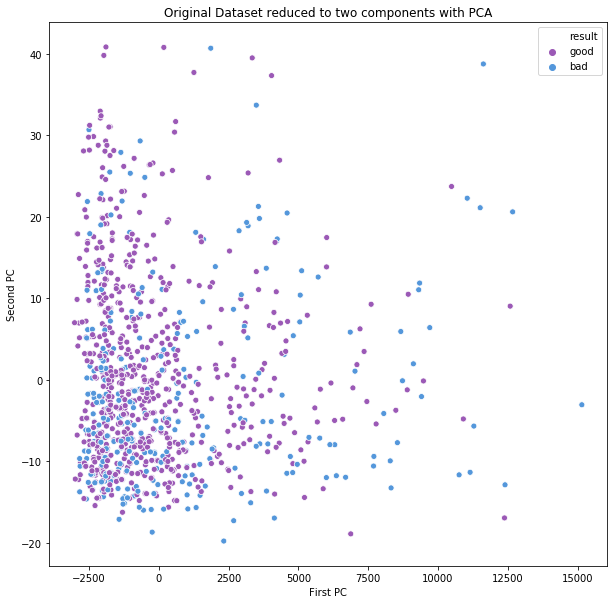

The percentage of variance explained by each components is: [9.99971656e-01 1.64259077e-05]


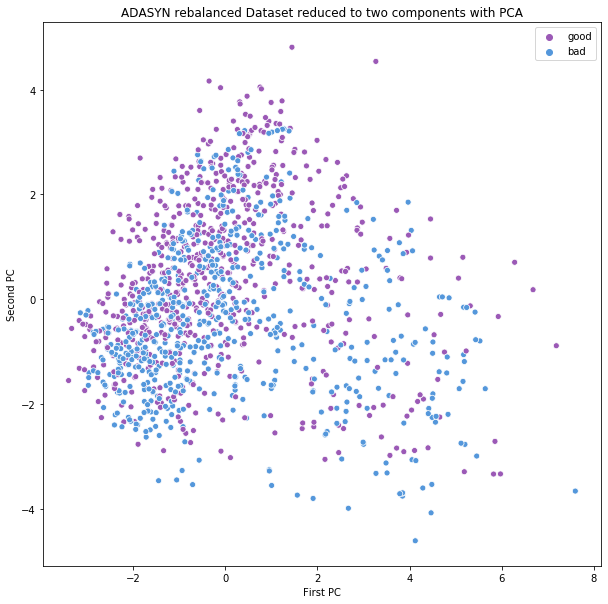

The percentage of variance explained by each components for the ADASYN dataset is: [0.08173847 0.05522576]


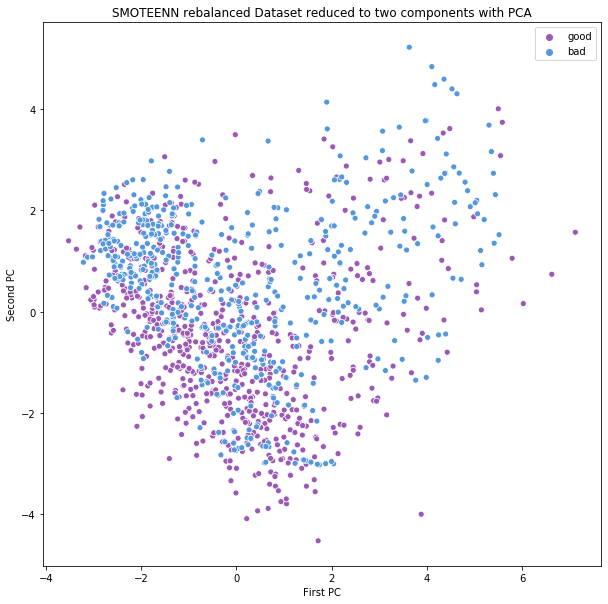

The percentage of variance explained by each components for the SMOTEENN dataset is: [0.0863731  0.05876373]


In [30]:
pca = PCA(n_components=2)

X_pca_visualization = pca.fit_transform(X)

fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x=X_pca_visualization[:, 0], y=X_pca_visualization[:, 1], hue=df["result"].replace({1:"good", 2:"bad"}))
ax.set_title("Original Dataset reduced to two components with PCA")
ax.set_xlabel("First PC")
ax.set_ylabel("Second PC")
plt.show()

print(f"The percentage of variance explained by each components is: {pca.explained_variance_ratio_}")

pca = PCA(n_components=2)
X_ada, y_ada =  ada.fit_resample(scaler.fit_transform(X), y)
X_pca_visualization_ada = pca.fit_transform(X_ada)

fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x=X_pca_visualization_ada[:, 0], y=X_pca_visualization_ada[:, 1], \
                hue=pd.Series(y_ada).replace({0:"good", 1:"bad"}))
ax.set_title("ADASYN rebalanced Dataset reduced to two components with PCA")
ax.set_xlabel("First PC")
ax.set_ylabel("Second PC")
plt.show()

print(f"The percentage of variance explained by each components for the ADASYN dataset is: {pca.explained_variance_ratio_}")

pca = PCA(n_components=2)
X_smoteenn, y_smoteenn =  smoteenn.fit_resample(scaler.fit_transform(X), y)
X_pca_visualization_smoteenn = pca.fit_transform(X_smoteenn)

fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x=X_pca_visualization_smoteenn[:, 0], y=X_pca_visualization_smoteenn[:, 1], \
                hue=pd.Series(y_smoteenn).replace({0:"good", 1:"bad"}))
ax.set_title("SMOTEENN rebalanced Dataset reduced to two components with PCA")
ax.set_xlabel("First PC")
ax.set_ylabel("Second PC")
plt.show()

print(f"The percentage of variance explained by each components for the SMOTEENN dataset is: {pca.explained_variance_ratio_}")

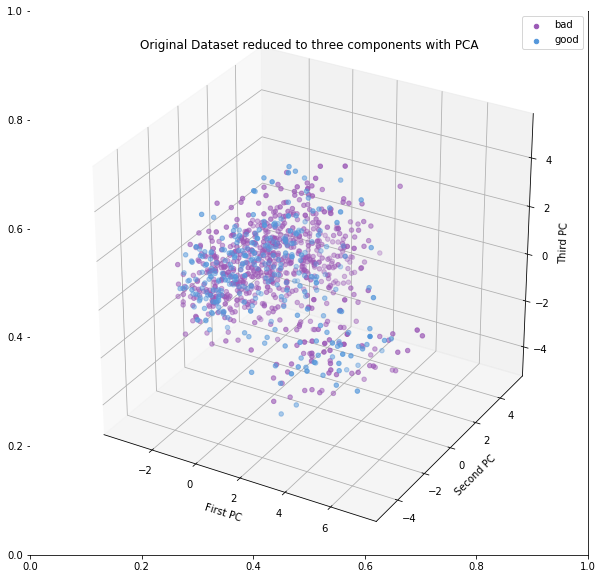

The percentage of variance explained by each components is: [0.07660301 0.05476354 0.04718037]


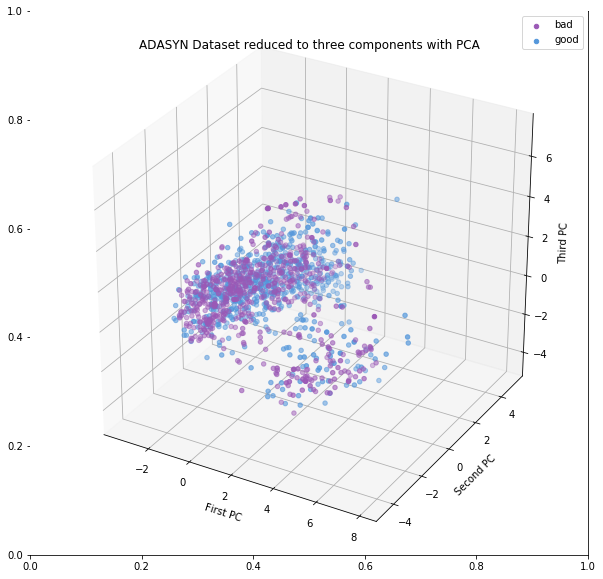

The percentage of variance explained by each components for the ADASYN dataset is: [0.08217559 0.05655374 0.04993276]


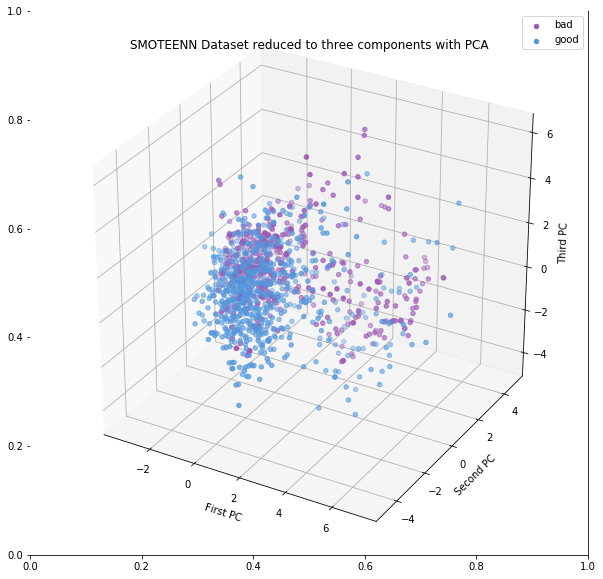

The percentage of variance explained by each components for the SMOTEENN dataset is: [0.08662857 0.05823026 0.04895075]


In [31]:
pca = PCA(n_components=3)
X_pca_visualization = pca.fit_transform(scaler.fit_transform(X))

fig, ax = plt.subplots(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca_visualization[df["result"] == 1, 0], \
           X_pca_visualization[df["result"] == 1, 1], \
           X_pca_visualization[df["result"] == 1, 2], label="bad")

ax.scatter(X_pca_visualization[df["result"] == 2, 0], \
           X_pca_visualization[df["result"] == 2, 1], \
           X_pca_visualization[df["result"] == 2, 2], label="good")
ax.legend()
ax.set_title("Original Dataset reduced to three components with PCA")
ax.set_xlabel("First PC")
ax.set_ylabel("Second PC")
ax.set_zlabel("Third PC")
plt.show()

print(f"The percentage of variance explained by each components is: {pca.explained_variance_ratio_}")

X_ada, y_ada =  ada.fit_resample(scaler.fit_transform(X), y)
X_pca_visualization_ada = pca.fit_transform(X_ada)

fig, ax = plt.subplots(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca_visualization_ada[y_ada==1, 0], \
           X_pca_visualization_ada[y_ada==1, 1], \
           X_pca_visualization_ada[y_ada==1, 2], label="bad")

ax.scatter(X_pca_visualization_ada[y_ada==0, 0], \
           X_pca_visualization_ada[y_ada==0, 1], \
           X_pca_visualization_ada[y_ada==0, 2], label="good")
ax.legend()
ax.set_title("ADASYN Dataset reduced to three components with PCA")
ax.set_xlabel("First PC")
ax.set_ylabel("Second PC")
ax.set_zlabel("Third PC")
plt.show()

print(f"The percentage of variance explained by each components for the ADASYN dataset is: {pca.explained_variance_ratio_}")

X_smoteenn, y_smoteenn =  smoteenn.fit_resample(scaler.fit_transform(X), y)
X_pca_visualization_smoteenn = pca.fit_transform(X_smoteenn)

fig, ax = plt.subplots(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca_visualization_smoteenn[y_smoteenn==1, 0], \
           X_pca_visualization_smoteenn[y_smoteenn==1, 1], \
           X_pca_visualization_smoteenn[y_smoteenn==1, 2], label="bad")

ax.scatter(X_pca_visualization_smoteenn[y_smoteenn==0, 0], \
           X_pca_visualization_smoteenn[y_smoteenn==0, 1], \
           X_pca_visualization_smoteenn[y_smoteenn==0, 2], label="good")
ax.legend()
ax.set_title("SMOTEENN Dataset reduced to three components with PCA")
ax.set_xlabel("First PC")
ax.set_ylabel("Second PC")
ax.set_zlabel("Third PC")
plt.show()

print(f"The percentage of variance explained by each components for the SMOTEENN dataset is: {pca.explained_variance_ratio_}")

#### Choosing the best number of components

As already said we choose the number of components by looking at the proportion of variance explained by each one of these. We can do that by plotting the cumulative proportion of variance explained and the proportion of variance explained in a graph as the number of components increase. The rule of thumb is to find an elbow in the graph or to consider a PVE of around $85\%$

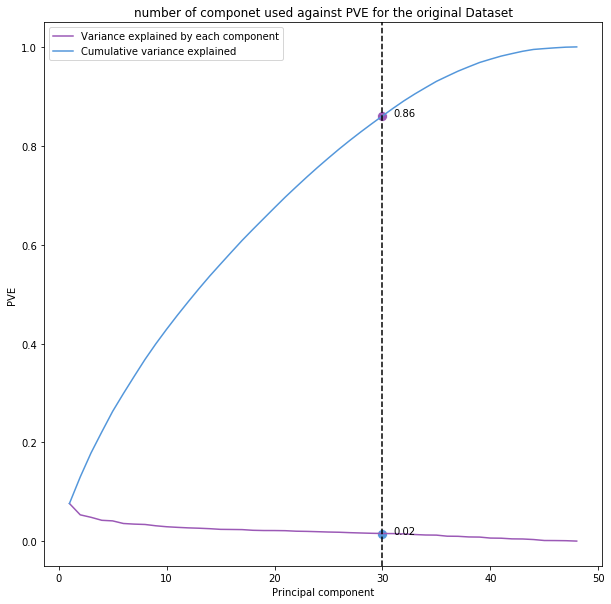

In [32]:
pca = PCA(n_components=X_train.shape[1])
c_analyzed = 30

pca.fit(X_train)
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.lineplot(x=range(1, X_train.shape[1]+1), y=pca.explained_variance_ratio_, label="Variance explained by each component")
ax = sns.lineplot(x=range(1, X_train.shape[1]+1), y=np.cumsum(pca.explained_variance_ratio_), label="Cumulative variance explained")
ax = sns.scatterplot(x=[c_analyzed], y=[np.cumsum(pca.explained_variance_ratio_)[c_analyzed-1]], s=100)
ax.text(c_analyzed+1, np.cumsum(pca.explained_variance_ratio_)[c_analyzed-1], f"{np.cumsum(pca.explained_variance_ratio_)[c_analyzed-1]:.2f}",\
       horizontalalignment='left')

ax = sns.scatterplot(x=[c_analyzed], y=[pca.explained_variance_ratio_[c_analyzed-1]], s=100)
ax.text(c_analyzed+1, pca.explained_variance_ratio_[c_analyzed-1], f"{pca.explained_variance_ratio_[c_analyzed-1]:.2f}",\
       horizontalalignment='left')
plt.axvline(c_analyzed, color="black", ls="--")
ax.set_title("number of componet used against PVE for the original Dataset")
ax.set_xlabel("Principal component")
ax.set_ylabel("PVE")
plt.show()

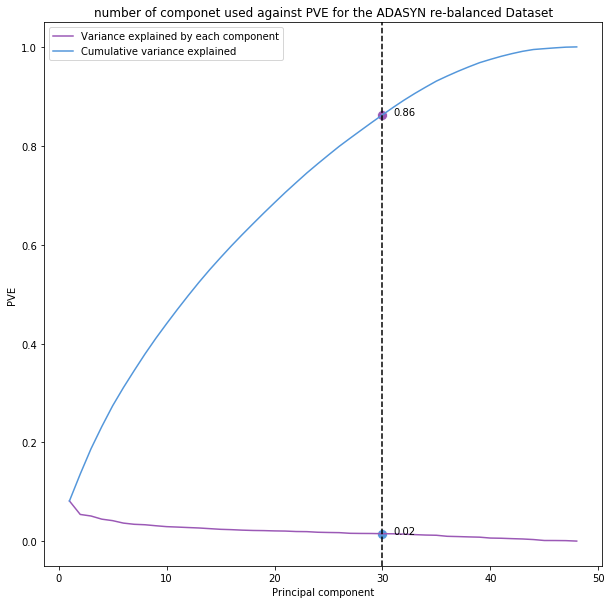

In [33]:
pca = PCA(n_components=X_train_ada.shape[1])

pca.fit(X_train_ada)
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.lineplot(x=range(1, X_train_ada.shape[1]+1), y=pca.explained_variance_ratio_, label="Variance explained by each component")
ax = sns.lineplot(x=range(1, X_train_ada.shape[1]+1), y=np.cumsum(pca.explained_variance_ratio_), label="Cumulative variance explained")
ax = sns.scatterplot(x=[c_analyzed], y=[np.cumsum(pca.explained_variance_ratio_)[c_analyzed-1]], s=100)
ax.text(c_analyzed+1, np.cumsum(pca.explained_variance_ratio_)[c_analyzed-1], f"{np.cumsum(pca.explained_variance_ratio_)[c_analyzed-1]:.2f}",\
       horizontalalignment='left')

ax = sns.scatterplot(x=[c_analyzed], y=[pca.explained_variance_ratio_[c_analyzed-1]], s=100)
ax.text(c_analyzed+1, pca.explained_variance_ratio_[c_analyzed-1], f"{pca.explained_variance_ratio_[c_analyzed-1]:.2f}",\
       horizontalalignment='left')
plt.axvline(c_analyzed, color="black", ls="--")
ax.set_title("number of componet used against PVE for the ADASYN re-balanced Dataset")
ax.set_xlabel("Principal component")
ax.set_ylabel("PVE")
plt.show()

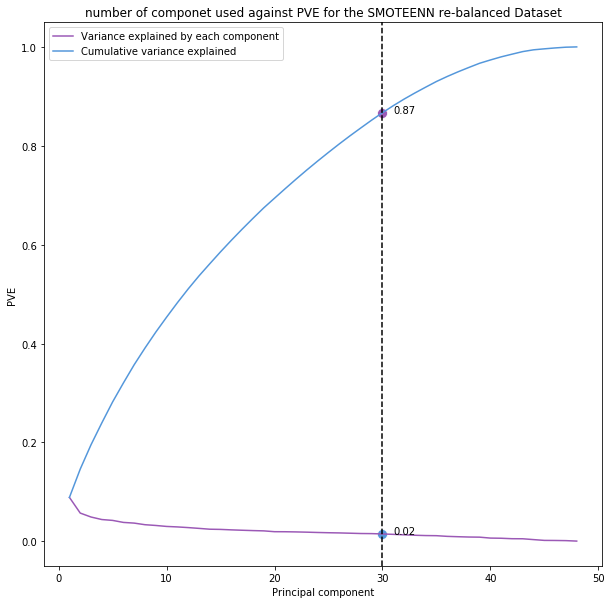

In [34]:
pca = PCA(n_components=X_train_smoteenn.shape[1])

pca.fit(X_train_smoteenn)
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.lineplot(x=range(1, X_train_smoteenn.shape[1]+1), y=pca.explained_variance_ratio_, label="Variance explained by each component")
ax = sns.lineplot(x=range(1, X_train_smoteenn.shape[1]+1), y=np.cumsum(pca.explained_variance_ratio_), label="Cumulative variance explained")
ax = sns.scatterplot(x=[c_analyzed], y=[np.cumsum(pca.explained_variance_ratio_)[c_analyzed-1]], s=100)
ax.text(c_analyzed+1, np.cumsum(pca.explained_variance_ratio_)[c_analyzed-1], f"{np.cumsum(pca.explained_variance_ratio_)[c_analyzed-1]:.2f}",\
       horizontalalignment='left')

ax = sns.scatterplot(x=[c_analyzed], y=[pca.explained_variance_ratio_[c_analyzed-1]], s=100)
ax.text(c_analyzed+1, pca.explained_variance_ratio_[c_analyzed-1], f"{pca.explained_variance_ratio_[c_analyzed-1]:.2f}",\
       horizontalalignment='left')
plt.axvline(c_analyzed, color="black", ls="--")
ax.set_title("number of componet used against PVE for the SMOTEENN re-balanced Dataset")
ax.set_xlabel("Principal component")
ax.set_ylabel("PVE")
plt.show()

We choose to use $30$ components which preserve a PVE of around $85\%$.

In [35]:
pca = PCA(c_analyzed)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

### Classification Task

In order to perform the classification task we will use several different algorithms:

- K-Nearest Neighbors
- Linear Support Vector Machines
- RBF Support Vector Machines
- Logistic Regression
- Decision Trees
- Random Forest

### Metrics used

For measuring the performances of a classification model different metrics can be used depending on the particular problem and situation. In fact a sample can be classified in several ways and depending on the outcome of the classification and on the true label of the sample we can have different configurations. In particular for a binary classification problem in which we could have two possible values for the label (let's say a positive and a negative value) we can define the following outcomes :

- **True Positive TP**: this outcome occurs when the classifier correctly predicts the positive label of the sample.
- **True Negative TN**: this outcome occurs when the classifier correctly predicts the negative label of the sample.
- **False Positive FP**: this outcome occurs when the classifier wrongly predicts a positive label for the sample, but the true label was negative
- **False Positive FN**: this outcome occurs when the classifier wrongly predicts a negative label for the sample, but the true label was positive

A good visualization for examining the number of TP, TN, FP and FN is the confusion matrix. In the particular case of a binary classification problem this is a $2\times 2$ matrix containg on each row the instance of the true class and on each column the instance of the predicted class (or viceversa), thus obtaining:
<figure>
<img src="media/conf_matrix.jpeg" style="width: 400px;">
    <figcaption><center><i>Confusion matrix, note how 0 indicates negative and 1 positive. <a href="https://towardsdatascience.com/demystifying-confusion-matrix-29f3037b0cfa">Source</a></i></center></figcaption>
</figure>


According to these definitions we can introduce several metrics for defining how well our model predicts the labels of a particular set of features. some of these are:

- Accuracy:
    This is the simplest and most known one, it is the ratio of correctly classified samples in the dataset:
    $Accuracy = \frac{\text{Number of correctly classified predictions}}{\text{Total number of predictions}}$
    
    accuracy can also be written as:
    
    $Accuracy = \frac{\text{TP}+\text{TN}}{\text{TP}+\text{TN}+\text{FP}+\text{FN}}$
    
    
- Precision:
    Sometimes accuracy is not enough, it could happen that we want to know what is the proportion of true positives among all samples classifed as positives, this is precision:
    
    $Precision = \frac{\text{TP}}{\text{TP}+\text{FP}}$
    
    
- Recall:
    Recall on the other hand wants to measure the proportion of actual positives that were classified correclty:
    
    $Recall = \frac{\text{TP}}{\text{TP}+\text{FN}}$
    
In the following figure we could see graphically the logic behind precision and recall:
<figure>
<img src="media/Precisionrecall.png" style="width: 400px;">
    <figcaption><center><i>Precision and Recall. <a href="https://en.wikipedia.org/wiki/Precision_and_recall">Source</a></i></center></figcaption>
</figure>
    
To evaluate a model we have to both look at precision and recall, but unfortunately these measures are sometimes in conflict. This means that improving precision typically reduces recall and viceversa. A tradeoff between these two measures is needed. A measures which tries to do that is:

- $F_1$ score:
    This is the armonic mean between precision and recall, defined as:
    $F_1 = 2\times\frac{Precision\times Recall}{Precision + Recall}$

In the case of the german credit dataset accuracy may not be the best metric to assess the performances of our model. That's basically for two reasons: first the dataset is imbalanced (at least for the models fitted without ADASYN or SMOTEENN), second for the bank issuing the credit a false negative is way more problematic than a false positive. In fact the bank wants to maximize its profit so it is worse to give money to an applicant which has a bad credit score (False negative) than not giving money to an applicant that has a good credit score (False positive). In the first case in fact the bank incurs in the risk of losing all the amount of money lended, while in the second case if the bank denies a loan to an applicant which has an high likelihood of repaying it risks of losing only the interests.
For this reason attached to the dataset description is present a penalty matrix indicating how each outcome of the classification should be penalized. In particular the matrix suggested is:

<figure>
<img src="media/penalty_matrix.jpg" style="width: 400px;">
    <figcaption><center><i>Penalty matrix</i></center></figcaption>
</figure>

As a score measure we could use the average penalty of the dataset, of course in this case lower is better.

we could argue that a true negative should have a negative penalty, while a false negative an higher penalty. In the literature other penalty matrices have been proposed to deal with this dataset (other matrices are reported in [3]). In order to compare different way of penalize our models we introduce an adjusted penalty matrix defined as:
<figure>
<img src="media/penalty_matrix_adj.jpg" style="width: 400px;">
    <figcaption><center><i>Penalty matrix adjusted</i></center></figcaption>
</figure>

As we saw the cost of a false negative for the bank is higher than the cost of a false positive. We are then interested in a F-measure that will summarize a model’s ability to minimize misclassification errors for the positive class, but we want to favor models that are better are minimizing false negatives over false positives.
We can obtain this by using a measure which computes the <i>weighted</i> harmonic mean between precision and recall and favors high recall scores over precision ones. This measure is a generalization of the $F_1$ measures and is called $F_{\beta}$, where $\beta$ is the parameter that defines the weighting of the two scores.
\begin{equation*}
F_{\beta}=\frac{(1+\beta^2)\times Precision\times Recall}{\beta^2\times Precision+Recall}
\end{equation*}

A $\beta$ of $2$ will give more weight to recall over precision, this is the measure that we will use in the dataset and it is calleD the $F_2$ measure:
\begin{equation*}
F_2=\frac{5\times Precision\times Recall}{4\times Precision+Recall}
\end{equation*}

The $F_2$ measure will be used for training, all of the other introduced measures will be reported for testing as well in order to make a comparison.

In [36]:
default_weighting = {"TP":0,\
                        "TN":0,\
                        "FP":1,\
                        "FN":5}

adjusted_weighting = {"TP":0,\
                        "TN":-1,\
                        "FP":1,\
                        "FN":10}                        

def compute_penalty(y, y_hat, weight_matrix):
    
    penalty = 0
    count = 0
    for y_i, y_hat_i in zip(y, y_hat):
        
        # True Positive Case
        if(y_i == 1 and y_hat_i == 1):
            penalty += weight_matrix["TP"]
        
        # True Negative Case
        if(y_i == 0 and y_hat_i == 0):
            penalty += weight_matrix["TN"]
            
        # False Positive Case
        if(y_i == 0 and y_hat_i == 1):
            penalty += weight_matrix["FP"]        
            
        # False Negative Case
        if(y_i == 1 and y_hat_i == 0):
            penalty += weight_matrix["FN"]
        
        count += 1
            
    return penalty / count       

#### Receiver Operating Characteristic

Receiver Operating Characterisc curves are a method for measuring performances in the case of binary classification problems. In this curve are plotted the False Positive Rate (x-axis) (specificity $\frac{TN}{FP+TN}$) and the True Positive Rate (y-axis) (a.k.a. recall or sensitivity) at the varying of certain thresholds on the probability that a particular algorithm outputs a the positive value. The idea here is that it can be more flexible to predict the probability that a sample belong to a certain class rather than predicting only the labels. Thus ROC curves provides a diagnostic tool to help the interpration of the probabilistic forecast of an algorithm. When predicting the probability that a sample belong to the positive class we can use a threshold to output a label, for example we could say that if the probability of class $1$ is greater than $\frac{1}{2}$ then we output the label $1$. At the varying of this threshold we could compute the true positive and false positive rate and plot it on a graph.
The shape of this curve contains a lot of information, for example lower values for the x-axis indicate that there are less false positives and a lot of true negatives, while high y-axis values indicate an high number of true positive and consequently a lower number of false negatives. It is easy to see that the ideal ROC curve is a curve which passes for the point $(0,1)$ in the ROC space. On the other hand a curve which is simply a $45^{\circ}$ degree line is like a random guessing (the true positive rate is equal to the false positive rate for every threshold); we want our classifiers to be better than this line.

<figure>
<img src="media/roc-curve-v2.png" style="width: 400px;">
    <figcaption><center><i>Roc Curves. <a href="https://glassboxmedicine.com/2019/02/23/measuring-performance-auc-auroc/"> Source</a></i></center></figcaption>
</figure>

An important value to consider while looking at a ROC is the Area Under The Curve (AUC). This is a number between $0$ and $1$ which tells us how much the model is capable of distinguishing between the classes. The higher the AUC the better the model.

It is very important to note that ROC curves are not useful in case of extreme imbalance in the data. That's because the TPR only depends on the positives in the data. The AUC paramenter assesses the overall performance of the model, not its ability at correctly classifying the minority class. For this reason the ROC curve is not recomended in such scenarios. In the case of the German Credit Dataset the imbalancement between the classes is not so high, so the ROC curve could be used also for the non re-balanced sets

### Validation tecniques

A common problem in machine learning is that the models need specific hyperparameters and this set of parameters is higly problem dependent. So every time we want to apply some ML algorithm we must perform a tuning phase in which we fit different models with different parameters and we keep the best model. A common error is to perform this tuning on the training set. This would cause major overfitting. In fact it could happen that the model achieves fantastic performances on the training set, but very poor on the test set. For this reason there are various validation tecniques that we can use.

**Holdout**
This is the most simple validation technique. It consists in splitting the data in three sets, training, validation and testing. The training set is used for training the model, the validation set to evaluate the model in order to find the best hyperparameters and finally the test set for testing the model performances on data which was never seen by the algorithm during training.

**k-Fold Cross Validation**
The problem with the holdout tecnique is that if the dataset has not so many samples we can incur in the situation of not using enough data for training, and this could be a problem, because machine learning algorithms need lots of data.
To cope with this problem we can use cross validation.
The goal of this method is to give an accurate estimate of the metrics that we are evaluating without wasting too much data.
In this case we do not split our dataset into training, validation and testing, but only into training and testing. The training set is then partitioned in $k$ folds of size $\frac{m}{k}$ ($m$ is the size of the training set). Then we leave one fold out and we train on the remainng $k-1$ folds. We evaluate on the fold which was left out from the training. We repeat this procedure $k$ times, one from each fold, obtaining $k$ cross validation scores. We then compute the average of these scores. Usually $k$-Fold CV is used for small and medium datasets in order to have more accurate scores with respect to holdout. When the dataset is big usually the holdout tecnique is used, because of course is faster than $k$-fold CV and the data is enough to ensure convergence of the model on the training set.
<figure>
<img src="media/KfoldCV.gif" style="width: 400px;">
    <figcaption><center><i>$k$-Fold Cross validation in action. <a href="https://en.wikipedia.org/wiki/Cross-validation_(statistics)"> Source</a></i></center></figcaption>
</figure>

**Leave One Out**
A particular case of cross validation is the Leave One Out CV. In this case if we call $m$ the number of samples of the dataset we use $m$ folds. Then at each step we use only one sample for validation and the others for training, then we average the reult. This is particularly useful to squeeze the most from the dataset and it is done only for very small datasets. Of course this is a very expensive tecnique and can require a lot of time on bigger datasets.

**Stratified CV**
It is important to point out that the cross validation is performend in such a way to preserve the label distribution of the dataset. This tecnique is called Stratified Cross Validation.
<figure>
<img src="media/stratCV.png" style="width: 400px;">
    <figcaption><center><i>Stratified $k$-Fold Cross validation in action. <a href="https://stats.stackexchange.com/questions/49540/understanding-stratified-cross-validation"> Source</a></i></center></figcaption>
</figure>

In the following sections we will use a $10$-Fold Stratified Cross Validation on the training set. It is important to note that in order to make a better tuning the ADASYN and SMOTEENN techniques must only be applied on the indices used for training, so at each CV step we apply to the train data ADASYN or SMOTEENN (in the case of ADASYN+PCA we apply PCA here after ADASYN) in order to not alterate the validation process. The data used for validation in fact must belong to the underlying data distribution, without any alteration.

### A baseline

As with every classification task we must start by defining a baseline model. This is the starting point for performing model selection and evaluation. The simpler model we can make here is the one which classifies every sample as positive, thus obtaining a base value for $F_2$.

In [37]:
results_df = pd.DataFrame(columns=["model_name", "parameters", "training_score (f2)","f1_test", "f2_test", "accuracy_test", \
                                   "penalty_default_matrix", "penalty_adj_matrix"])

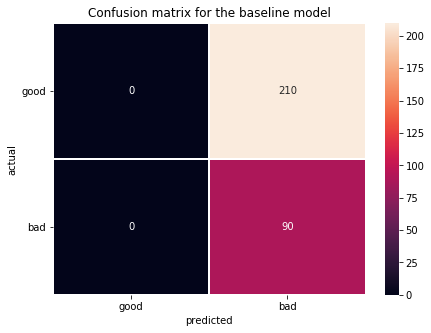

In [38]:
y_hat_baseline = np.ones((300, 1))

# Train score
f2_train = fbeta_score(y_train, np.ones((700, 1)), beta=2)

# Train score
f2_test = fbeta_score(y_test, y_hat_baseline, beta=2)

# f1 score
f1_test = f1_score(y_test, y_hat_baseline)

# Accuracy
accuracy_test = accuracy_score(y_test, y_hat_baseline)

# Penalty default weight
penalty_default = compute_penalty(y_test, y_hat_baseline, weight_matrix=default_weighting)

# Penalty adjusted weight 
penalty_adjusted = compute_penalty(y_test, y_hat_baseline, weight_matrix=adjusted_weighting)

output_df = pd.DataFrame(data=[[f1_test, f2_test, accuracy_test, penalty_default, penalty_adjusted]],\
        columns=["f1_test", "f2_test", "accuracy_test", "penalty_default_matrix", "penalty_adj_matrix"])

conf_matrix = confusion_matrix(y_test, y_hat_baseline)

fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, linewidth=0.5, xticklabels=["good", "bad"], fmt="g")
ax.set_yticklabels(labels=["good", "bad"], rotation=0) 
ax.set_xlabel("predicted")
ax.set_ylabel("actual")
ax.set_title("Confusion matrix for the baseline model")
plt.show()

In [39]:
classifier_df = pd.DataFrame(data = [["Baseline model", "N/A" , f2_train]], \
        columns=["model_name", "parameters", "training_score (f2)"])
results_df = results_df.append(pd.concat([classifier_df, output_df], axis=1, sort=False))

In [40]:
results_df

,model_name,parameters,training_score (f2),f1_test,f2_test,accuracy_test,penalty_default_matrix,penalty_adj_matrix
0,Baseline model,N/A,0.681818,0.461538,0.681818,0.3,0.7,0.7


In [41]:
summary_df = results_df.copy()

### Code for performing Cross Validation

In [42]:
def trainClassifier(X_train, y_train, model_name, classifier, params, score, score_parameters=None,\
                    greater_is_better=True, verbose=False, adasyn=None, smoteenn=None, pca=None, standardize=None):

    kf = StratifiedKFold(10)
    
    
    train_scores = []

    if greater_is_better:
        best_score = 0
    else:
        best_score = sys.float_info.max
        
    for config in ParameterGrid(params):
        train_scores_run = []
        counts = []
        for train_indices, valid_indices in kf.split(X_train, y_train):
            counts.append(len(train_indices))
            X_train_kf = X_train[train_indices]
            y_train_kf = y_train[train_indices]
            X_valid_kf = X_train[valid_indices]
            y_valid_kf = y_train[valid_indices]
                       
            if standardize is not None: 
                X_train_kf = standardize.fit_transform(X_train_kf)
                X_valid_kf = standardize.transform(X_valid_kf)
            
            if adasyn is not None:
                X_train_kf, y_train_kf = adasyn.fit_resample(X_train_kf, y_train_kf)
                
            if smoteenn is not None:
                X_train_kf, y_train_kf = smoteenn.fit_resample(X_train_kf, y_train_kf)
            
            if pca is not None:
                X_train_kf = pca.fit_transform(X_train_kf)
                X_valid_kf = pca.transform(X_valid_kf)

            # keep track of the number of elements in each split
            model = classifier(**config)
            model.fit(X_train_kf, y_train_kf)
            y_hat = model.predict(X_valid_kf)
            train_score = score(y_valid_kf, y_hat, **score_parameters)
            train_scores_run.append(train_score)

        if(greater_is_better):
            if np.average(train_scores_run, weights=counts) > best_score:
                best_score = np.average(train_scores_run, weights=counts)
                best_config = config
                if(verbose):
                    print("New best score obtained")
                    print(f"Training with: {config}")
                    print(f"Total Score obtained with cross validation: {best_score}\n")
        else:
            if np.average(train_scores_run, weights=counts) < best_score:
                best_score = np.average(train_scores_run, weights=counts)
                if(verbose):
                    print("New best score obtained")
                    print(f"Training with: {config}")
                    print(f"Total Score obtained with cross validation: {best_score}\n")

        train_scores.append(np.average(train_scores_run, weights=counts))

    output_df = pd.DataFrame(data = [[model_name, best_config ,best_score]], \
        columns=["model_name", "parameters", "training_score (f2)"])

    return output_df

def testClassifier(X_train, y_train, X_test, y_test, classifier, best_params, adasyn=None, smoteenn=None, pca=None, standardize=None, proba=False):
    # Train model obtained with best hyperparameters              
    if standardize is not None: 
        X_train = standardize.fit_transform(X_train)
        X_test = standardize.transform(X_test)
    
    if adasyn is not None:
        X_train, y_train = ada.fit_resample(X_train, y_train)
        
    if smoteenn is not None:
        X_train, y_train = smoteenn.fit_resample(X_train, y_train)
        
    if pca is not None:
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
    
    best_model = classifier(**best_params)
    best_model.fit(X_train, y_train)
    y_hat = best_model.predict(X_test)

    # f1 score
    f1_test = f1_score(y_test, y_hat)
    
    # f2 score
    f2_test = fbeta_score(y_test, y_hat, beta=2)

    # Accuracy
    accuracy_test = accuracy_score(y_test, y_hat)# Train model obtained with best hyperparameters

    # Penalty default weight
    penalty_default = compute_penalty(y_test, y_hat, weight_matrix=default_weighting)

    # Penalty adjusted weight 
    penalty_adjusted = compute_penalty(y_test, y_hat, weight_matrix=adjusted_weighting)

    output_df = pd.DataFrame(data=[[f1_test, f2_test, accuracy_test, penalty_default, penalty_adjusted]],\
        columns=["f1_test", "f2_test", "accuracy_test", "penalty_default_matrix", "penalty_adj_matrix"])

    conf_matrix = confusion_matrix(y_test, y_hat)
    
    if proba == False:
        y_score = best_model.decision_function(X_test)
    else:
        y_score = best_model.predict_proba(X_test)[:, 1]
        
    fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
    roc_auc = auc(fpr, tpr)
    roc = [fpr, tpr]  
    
    return output_df, conf_matrix, roc, roc_auc

def performAnalysis(train_Xs, y_train, test_Xs, y_test, model_names, classifier,\
                    params, score, score_parameters, greater_is_better=True, verbose=False,\
                    adasyn=None, smoteenn=None, pca=None, standardize=None, proba=False):
    
    # Find best parameters with cross validation
    conf_matrices = []
    rocs = []
    roc_aucs = []
    
    results_df = pd.DataFrame(columns=["model_name", "parameters", "training_score (f2)", "f1_test", "f2_test",\
                                       "accuracy_test", "penalty_default_matrix", "penalty_adj_matrix"])
    
    for X_train, X_test, model_name in zip(train_Xs, test_Xs, model_names):
        classifier_df = trainClassifier(X_train, y_train, model_name, classifier, params=params, score=score,\
             score_parameters=score_parameters, greater_is_better=True,verbose=False, adasyn=adasyn, pca=pca, smoteenn=smoteenn, standardize=standardize)
        
        tests_df, conf_matrix, roc, auc = testClassifier(X_train, y_train, X_test, y_test, classifier, \
                                                classifier_df["parameters"].to_dict()[0], adasyn=adasyn, smoteenn=smoteenn, pca=pca, standardize=standardize, proba=proba)
        conf_matrices.append(conf_matrix)
        rocs.append(roc)
        roc_aucs.append(auc)
                                                                         
        results_df = results_df.append(pd.concat([classifier_df, tests_df], axis=1, sort=False))
                                                                
    return results_df, conf_matrices, rocs, roc_aucs

def draw_rocs(rocs, roc_aucs, roc_titles):
    fig, axs = plt.subplots(2, 3, figsize=(25, 10))
    i = 0
    j = 0

    for roc, roc_auc, roc_title in zip(rocs, roc_aucs, roc_titles):
        lw=2
        sns.lineplot(roc[0], roc[1], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, ax=axs[j, i])
        sns.lineplot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', ax=axs[j, i])
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        axs[j, i].set_xlabel('False Positive Rate')
        axs[j, i].set_ylabel('True Positive Rate')
        axs[j, i].set_title(roc_title)
        axs[j, i].legend(loc="lower right")

        i += 1
        if i%3 == 0 and i != 0:
            j += 1
            i = 0

    plt.show()   
    
def draw_conf_matrices(conf_matrices, plot_titles):
    fig, axs = plt.subplots(2, 3, figsize=(25, 10))
    i = 0
    j = 0

    for conf_matrix, plot_title in zip(conf_matrices, plot_titles):
        sns.heatmap(conf_matrix, annot=True, linewidth=0.5, xticklabels=["good", "bad"], ax=axs[j, i], fmt="g")
        axs[j, i].set_yticklabels(labels=["good", "bad"], rotation=0) 
        axs[j, i].set_xlabel("predicted")
        axs[j, i].set_ylabel("actual")
        axs[j, i].set_title(plot_title)

        i += 1
        if i%3 == 0 and i != 0:
            j += 1
            i = 0
    plt.show()

def run_classifier(proba=True):
    results_df, conf_matrices, rocs, roc_aucs = performAnalysis(\
                                                [X_train_raw], y_train, [X_test_raw], y_test, model_names=[model_names[0]], \
                                                classifier=classifier, params=params, score=fbeta_score, score_parameters={"beta":2},\
                                                greater_is_better=True, verbose=False, proba=proba, standardize=scaler)

    results_df_pca, conf_matrices_pca, rocs_pca, roc_aucs_pca, = performAnalysis(\
                                                [X_train_raw], y_train, [X_test_raw], y_test, model_names=[model_names[1]], \
                                                classifier=classifier, params=params, score=fbeta_score, score_parameters={"beta":2},\
                                                greater_is_better=True, verbose=False, proba=proba, pca=pca, standardize=scaler)

    rocs.append(rocs_pca[0])
    roc_aucs.append(roc_aucs_pca[0])
    results_df = results_df.append(results_df_pca)
    conf_matrices.append(conf_matrices_pca[0])

    results_df_ada, conf_matrices_ada, rocs_ada, roc_aucs_ada = performAnalysis(\
                                                [X_train_raw], y_train, [X_test_raw], y_test, model_names=[model_names[2]],\
                                                classifier=classifier, params=params, score=fbeta_score, score_parameters={"beta":2},\
                                                greater_is_better=True, verbose=False, proba=proba, adasyn=ada, pca=None, standardize=scaler)

    results_df = results_df.append(results_df_ada)
    conf_matrices.append(conf_matrices_ada[0])
    rocs.append(rocs_ada[0])
    roc_aucs.append(roc_aucs_ada[0])

    results_df_ada_pca, conf_matrices_ada_pca, rocs_ada_pca, roc_aucs_ada_pca = performAnalysis(\
                                                [X_train_raw], y_train, [X_test_raw], y_test, model_names=[model_names[3]],\
                                                classifier=classifier, params=params, score=fbeta_score, score_parameters={"beta":2}, \
                                                greater_is_better=True, verbose=False, proba=proba, adasyn=ada, pca=pca, standardize=scaler)

    results_df = results_df.append(results_df_ada_pca)
    conf_matrices.append(conf_matrices_ada_pca[0])
    rocs.append(rocs_ada_pca[0])
    roc_aucs.append(roc_aucs_ada_pca[0])

    results_df_smoteenn, conf_matrices_smoteenn, rocs_smoteenn, roc_aucs_smoteenn = performAnalysis(\
                                                [X_train_raw], y_train, [X_test_raw], y_test, model_names=[model_names[4]],\
                                                classifier=classifier, params=params, score=fbeta_score, score_parameters={"beta":2}, \
                                                greater_is_better=True, verbose=False, proba=proba, smoteenn=smoteenn, pca=None, standardize=scaler)

    results_df = results_df.append(results_df_smoteenn)
    conf_matrices.append(conf_matrices_smoteenn[0])
    rocs.append(rocs_smoteenn[0])
    roc_aucs.append(roc_aucs_smoteenn[0])

    results_df_smoteenn_pca, conf_matrices_smoteenn_pca, rocs_smoteenn_pca, roc_aucs_smoteenn_pca = performAnalysis(\
                                                [X_train_raw], y_train, [X_test_raw], y_test, model_names=[model_names[5]],\
                                                classifier=classifier, params=params, score=fbeta_score, score_parameters={"beta":2}, \
                                                greater_is_better=True, verbose=False, proba=proba, smoteenn=smoteenn, pca=pca, standardize=scaler)

    results_df = results_df.append(results_df_smoteenn_pca)
    conf_matrices.append(conf_matrices_smoteenn_pca[0])
    rocs.append(rocs_smoteenn_pca[0])
    roc_aucs.append(roc_aucs_smoteenn_pca[0])
    
    return results_df, conf_matrices, rocs, roc_aucs

### K-Nearest Neighbors

Among all the various machine learning algorithms the $k$-Nearest Neighbors based techniques are the simplest ones. The main idea behind this technique is to assign the label of a given test sample $\mathbf{x}$ by looking at the labels of the nearest $k$ samples in the feature space and choosing as class for the sample the most rapresented label in its neighborhood.  So we can say that k-NN is a family of algorithms, one for each value of k. It is importat to note that in order to use
$k$-NN we must define a distance in the feature space to evaluate how far is any point from the given input set.
$k$-NN is a very lazy technique, there is not a real model built from input data in the training phase, but
the training samples are stored in a lookup table and in the test phase the distances between the training
samples and the test input are computed. Finally a majority vote is taken in the neighborhood of the
sample to assign its label, so we can see $k$-NN as a searching problem.

<figure>
    <table><tr><td bgcolor="white"><img src="media/knn-tc.png" style="width: 200px;"/></td><td bgcolor="white"><img src="media/knn-class.png" style="width: 200px;"/></td></tr></table>
    <figcaption><center><i>$k$-NN in action with $k=3$ at test time</i></center></figcaption>
</figure>

One of the main problem of $k$-NN is that the algorithms needs to compute the distance from every point in the dataset at test time. So even if the training is very fast (just store the training data), the testing phase can take a longer time. This problem is explained in detail in the this GIF:
<figure>
    <img src="media/KNN-Classification.gif", style="width: 400px;">
    <figcaption><center><i>$k$-NN for $k=5$. <a href="https://machinelearningknowledge.ai/k-nearest-neighbor-classification-simple-explanation-beginners/">Source</a></i></center></figcaption>
</figure>

A common choice for the distance is to use the Euclidean Distance, therefore we will use it, but $k$-NN can also be applied with other distances too.

We will now perform a grid search for:
- $K = 1, 3, 5, 7, 9, 11, 13, 15$

In [43]:
params = {
    "n_neighbors": [1, 3, 5, 7, 9, 11, 13, 15]
}
classifier = KNeighborsClassifier
model_names = ["K-NN", "K-NN PCA", "K-NN ADASYN", "K-NN ADASYN PCA", "K-NN SMOTEENN", "K-NN SMOTEENN PCA"]
conf_matr_titles = ["Confusion Matrix K-NN not reduced dimension", "Confusion Matrix K-NN PCA",\
               "Confusion Matrix K-NN ADASYN", "Confusion Matrix K-NN ADASYN PCA",\
               "Confusion Matrix K-NN SMOTEENN", "Confusion Matrix K-NN SMOTEENN PCA"]

roc_titles = ["ROC K-NN not reduced dimension", "ROC K-NN PCA",\
              "ROC K-NN ADASYN", "ROC K-NN ADASYN PCA",\
              "ROC K-NN SMOTEENN", "ROC K-NN SMOTEENN PCA"]
              

In [44]:
results_df, conf_matrices, rocs, roc_aucs = run_classifier(proba=True)

summary_df = summary_df.append(results_df)

results_df

,model_name,parameters,training_score (f2),f1_test,f2_test,accuracy_test,penalty_default_matrix,penalty_adj_matrix
0,K-NN,{'n_neighbors': 1},0.434267,0.468571,0.460674,0.690000,0.963333,1.226667
0,K-NN PCA,{'n_neighbors': 1},0.441170,0.448087,0.452539,0.663333,0.990000,1.280000
0,K-NN ADASYN,{'n_neighbors': 13},0.699003,0.544776,0.678439,0.593333,0.633333,0.566667
0,K-NN ADASYN PCA,{'n_neighbors': 13},0.677702,0.553506,0.693161,0.596667,0.603333,0.506667
0,K-NN SMOTEENN,{'n_neighbors': 13},0.670057,0.527132,0.643939,0.593333,0.700000,0.700000
0,K-NN SMOTEENN PCA,{'n_neighbors': 13},0.639863,0.585938,0.712928,0.646667,0.553333,0.406667


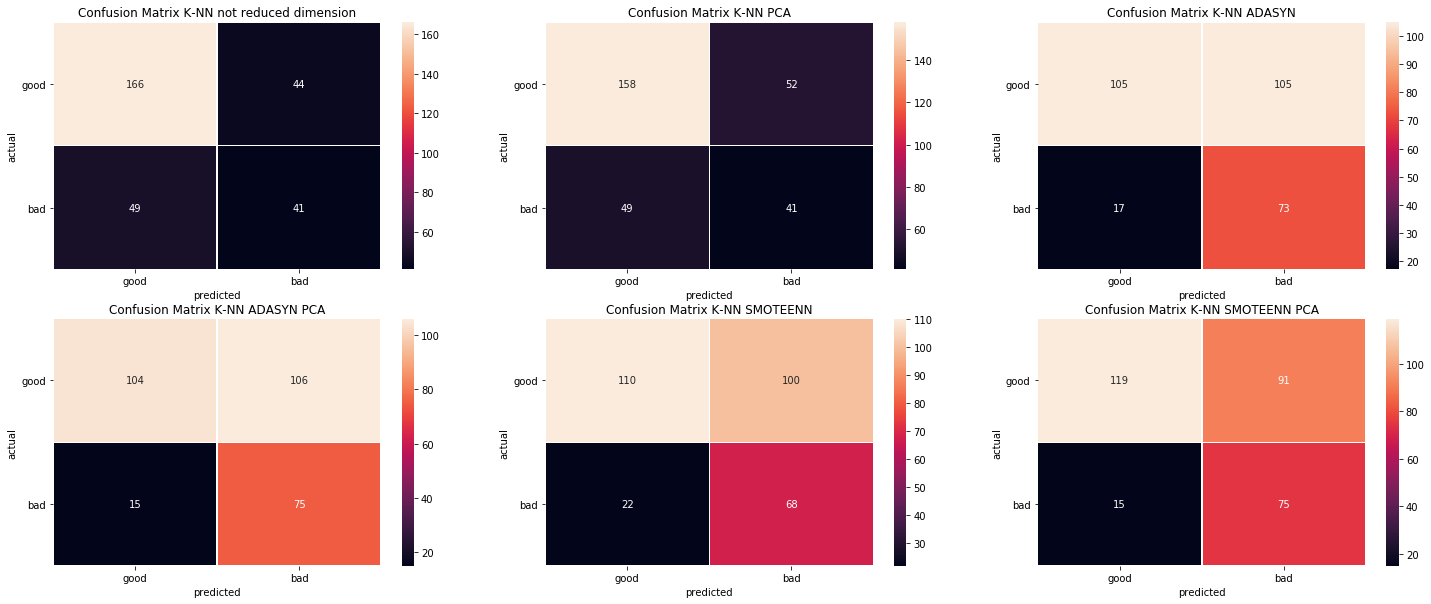

In [45]:
draw_conf_matrices(conf_matrices, conf_matr_titles)

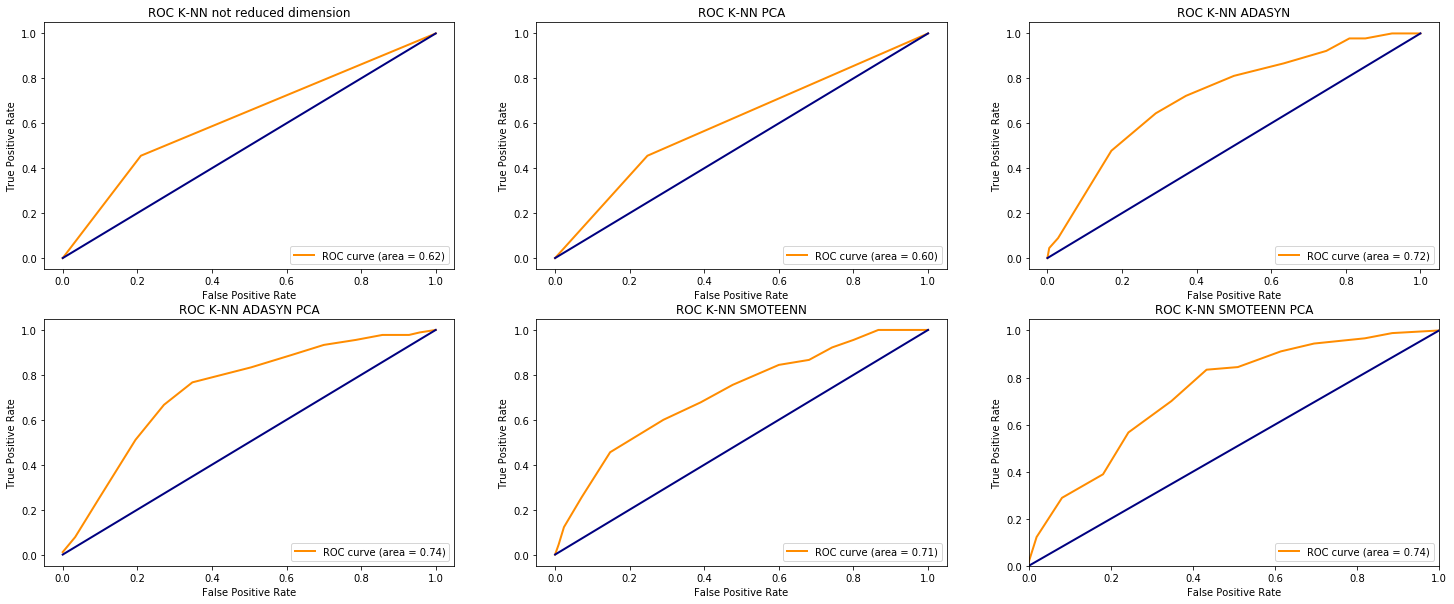

In [46]:
draw_rocs(rocs, roc_aucs, roc_titles)

### Support Vector Machines

Another very common and powerful family of machine learning algorithms is the Support Vector Machine (SVM) family. Given a binary classification problem the goal of SVMs is to find an hyperplane in a N-dimensional subspace which performs the best split of the labeled training data points into the two categories. With best split we intend the split which maximizes the margin between the classes; with margin we intend the distance between the hyperplane and its closest
samples in the feature space. In order to find this best hyperplane SVM sees the classification task as a
convex optimization problem that can be efficiently solved using Stochastic Gradient Descent. Furthermore SVM can be kernelized as we will see in detail in the next sections and be able to solve also non-linearly separable problems.
One of the main advantages of SVM besides it's flexibility is that the algorithm only cares about the points on the margin (the so-called support vectors), so this can yield to a small sample complexity even if the dimensionality of the feature space is high or even infinite.

#### Linear SVM

**Hard SVM**
In the linear case we want to find an hyperplane which separates the data and has the highest possible margin. we can define this hyperplane as  $f(x)=\langle \mathbf{w},\mathbf{x}\rangle+b$, where $\mathbf{w}$ is a vector orthogonal to the hyperplane and $b$ an intercept term.

<figure>
    <img src="media/svm.png", style="width: 400px;">
    <figcaption><center><i>SVM, hyperplanes and margin. <a href="https://towardsdatascience.com/support-vector-machine-vs-logistic-regression-94cc2975433f">Source</a></i></center></figcaption>
</figure>

When we define hyperplanes there is an hidden degree of fredoom in the scalar product. In fact the function associated to 
$(\mathbf{w},b)$ does not change if we rescale the hyperplane to $(\lambda\mathbf{w},{\lambda}b)$, for $\lambda\in\mathbb{R}^+$.
There will however be a change in the margin as measured by the function output, as opposed to the purely geometrical margin.
Having said so we can impose that a point belongs to the margin if $\langle \mathbf{w},\mathbf{x}\rangle+b=\pm 1$.
So we will perform our classification task by saying that a point belongs to a specific class if $\langle \mathbf{w},\mathbf{x}\rangle+b\geq1$
and belongs to the other class if $\langle \mathbf{w},\mathbf{x}\rangle+b\leq1$.
Now we will try to model an optimization form for this problem. Let's call a point on the margin $\mathbf{x}_+$ if it belongs to a class which is in the same direction respect to the hyperplane as the vector $\mathbf{w}$
and $\mathbf{x}_-$ if the point is in the opposite direction (belongs to the other class). So we can define the margin as:
\begin{equation*}
        \frac{\langle\mathbf{x}_+-\mathbf{x}_-,\mathbf{w}\rangle}{2\|\mathbf{w}\|}=
        \frac{1}{2\|\mathbf{w}\|}[\langle\mathbf{x}_+,\mathbf{w}\rangle-\langle\mathbf{x}_-,\mathbf{w}\rangle]
\end{equation*}

We can then sum and subtract the same quantity $\pm b$:
\begin{equation*}
        \frac{1}{2\|\mathbf{w}\|}\left\{[\langle\mathbf{x}_+,\mathbf{w}\rangle+b]-[\langle\mathbf{x}_-,\mathbf{w}\rangle+b]\right\}=
        \frac{1}{\|\mathbf{w}\|}
\end{equation*}
The value we just obtained is the margin. In SVM we have said that we want to maximize this quantity:
\begin{equation*}
        \max \frac{1}{\|\mathbf{w}\|}
\end{equation*}
<center>s.t.</center>
\begin{equation*}
        y_i[\langle \mathbf{w},\mathbf{x}\rangle+b]\geq1
\end{equation*}

and this is equivalent to minimize:
\begin{equation*}
        \min \frac{1}{2}\|\mathbf{w}\|^2
\end{equation*}
<center>s.t.</center>
\begin{equation*}
        y_i[\langle \mathbf{w},\mathbf{x}\rangle+b]\geq1
\end{equation*}
Where we wrote the problem in this way in order to be sure to have a differentiable twice function.
The problem we just stated is called the Primal Optimization Problem and using the Lagrangian multipliers we can derive the dual:
\begin{equation*}
        \mathcal{L}(\mathbf{w}, b, \alpha)=\frac{1}{2}\|\mathbf{w}\|^2-\sum_i\alpha_i[ y_i(\langle \mathbf{w},\mathbf{x}_i\rangle+b)-1]
\end{equation*}

Where we introduced $\alpha_i$ Lagrangian multipiers, $\alpha_i\geq 0$.
This means that optimality in $\mathbf{w}$, $b$ is at saddle point with $\alpha$ and that derivatives in $\mathbf{w}$, $b$ need to vanish.
The derivatives of the Lagrangian function with respect to $\mathbf{w}$ and $b$ are:
\begin{equation*}
        \partial_w\mathcal{L}(\mathbf{w}, b, \alpha)=\mathbf{w}-\sum_i\alpha_iy_i\mathbf{x_i}=0
\end{equation*}
\begin{equation*}
        \partial_b\mathcal{L}(\mathbf{w}, b, \alpha)=\sum_i\alpha_iy_i=0
\end{equation*}
so we can plug back the obtained terms into $\mathcal{L}$ and we obtain:
\begin{equation*}
        \max_\alpha-\frac{1}{2}\sum_{i,j}\alpha_i\alpha_jy_iy_j\langle\mathbf{x}_i,\mathbf{x}_j\rangle+\sum_i\alpha_i
\end{equation*}
<center>s.t.</center>
\begin{align*}
        \sum_i\alpha_iy_i=0,\\
        \alpha_i\geq0
\end{align*}
This is the dual optimization problem. We will found out solving this problem that most of the $\alpha$ are zero.
The only non zero Lagrangian multipliers are those associatied with points on the margin, so the optimal hyperplane can be written as
a linear combination of points on the margin. These vector support the decision, so they are called support vectors.
The SVM as described until now is called Hard SVM and it's working can be visualized in the animation below:
<figure>
    <img src="media/svm_gif.gif", style="width: 400px;">
    <figcaption><center><i>SVM in action. <a href="https://jeremykun.com/2017/06/05/formulating-the-support-vector-machine-optimization-problem/">Source</a></i></center></figcaption>
</figure>

**Soft SVM**

The main problem of the linear SVM that we have found is that it does not allow for any mistake, for this reason is called Hard SVM. But sometimes the data is noisy, or not completely linearly separable. We need to find a method to allow for some mistakes, this will bring to a model more robust to noise and outliers. In order to achieve this goal we can add some slack variables to the optimization problem, which will become:
\begin{equation*}
        \min_{\mathbf{w}, b} \frac{1}{2}\|\mathbf{w}\|^2+C\sum_i\xi_i
\end{equation*}
<center>s.t.</center>
\begin{align*}
        y_i\langle\mathbf{w},\mathbf{x}\rangle+b&\geq 1-\xi_i, \\
        \xi_i&\geq 0
\end{align*}

With this trick we get that violations are possible (the problem is always feasible), but penalized, so the goal of the optimization problem is to minimize that amount of slack. In this case too we can derive the dual problem:

\begin{equation*}
        \mathcal{L}(\mathbf{w}, b, \alpha)=\frac{1}{2}\|\mathbf{w}\|^2+C\sum_i\xi_i
        -\sum_i\alpha_i[ y_i(\langle \mathbf{w},\mathbf{x}_i\rangle+b)-1]
        -\sum_i\eta_i\xi_i
\end{equation*}
Then as in the previous case the optimality in $\mathbf{w}$, $b$, $\mathbf{\xi}$ is at saddle point with $\alpha$, $\eta$, so
the derivatives need to vanish.
\begin{equation*}
        \partial_{\mathbf{w}}\mathcal{L}(\mathbf{w}, b, \xi, \alpha, \eta)=
        \mathbf{w}-\sum_i\alpha_iy_i\mathbf{x}_i=0
\end{equation*}
\begin{equation*}
        \partial_{b}\mathcal{L}(\mathbf{w}, b, \xi, \alpha, \eta)=
        \sum_i\alpha_iy_i=0
\end{equation*}
\begin{equation*}
        \partial_{\xi_i}\mathcal{L}(\mathbf{w}, b, \xi, \alpha, \eta)=
        C-\alpha_i-\eta_i=0
\end{equation*}
So plugging everything again in the Lagrangian function yields:
\begin{equation*}
        \max_\alpha-\frac{1}{2}\sum_{i,j}\alpha_i\alpha_jy_iy_j\langle\mathbf{x}_i,\mathbf{x}_j\rangle+\sum_i\alpha_i
\end{equation*}
s.t.
\begin{align*}
        &\sum_i\alpha_iy_i=0,\\
        &\alpha_i\in[0,C]
\end{align*}
What is changing with respect to the hard margin case is that now we are limiting the value of each $\alpha_i$ to be not greater than $C$.
The effect of $C$ which is the constant determining the number of slack variables, determines which values $\alpha$ can take.
$C$ is proportional to the mistake I make and therefore it determines how soft or hard the margin is, the larger the $C$ the softer the margin,
so this parameters acts as a regularization term.

**Solving Linear SVM with Stochastic Gradient Descent**

We can rewrite the optimization problem of soft margin SVM as follows:
\begin{equation*}
        \min_{\mathbf{w}, b} \frac{1}{2}\|\mathbf{w}\|^2+C\sum_i\max(0, 1-y_i\mathbf{w}^T\mathbf{x}_i)
\end{equation*}

The second term in the minimization function is the hinge loss: it penalizes vectors that correspond to mistakes (soft constraint). Note that if the distance between the point and the plane is higher than the margin then the loss assumes value $0$. The function we just defined is convex in $\mathbf{w}$ so there exist a global minimum.
We can minimize the function with the Gradient Descent algorithm: for an arbitrary number of iterations (epochs) at each step we compute the gradient w.r.t. to $\mathbf{w}$ (we know that the gradient of a function is the direction of maximum increase). We can then take a step in the opposite direction towards the minimum.
The problem here is that the max function is not differentiable, so we can not compute the gradient (the limit of the difference quotient from the left is different from the one from the right). A solution is to compute the sub-gradient. A sub-tangent at a point is any hyperplane that lies below the function at the point. A sub-gradient is the slope of that line. So if we call the function to minimize $J$ we can compute the gradient of it:
\begin{equation*}
\nabla_{\mathbf{w}}J=\begin{cases}\mathbf{w}\;\text{if} \max(0, 1-y_i\mathbf{w}^T\mathbf{x}_i)=0\\
\mathbf{w}-Cy_i\mathbf{x}_i\;\text{otherwise}\end{cases}
\end{equation*}
The general Gradient Descent algorithm given the training set has the following steps:
1. Initialize $\mathbf{w}=0\in\mathbf{R}^d$
2. For each epoch $t = 1,...,T$:
     Update $\mathbf{w}\leftarrow\mathbf{w}-\gamma_t\nabla_{\mathbf{w}}^tJ$
3. Return $\mathbf{w}$

$\gamma_t$ is called the learning rate and it is a parameter useful in order to not make too big steps towards the minumum (there is the risk of overshooting it).
If we compute the gradient of all the training set at each step the algorithm may end up taking too much time to converge. For this reason we use the Stochastic Gradient Descent. This algorithms is like the GD, but computes the gradient only of a random sample of the data at each step. The SGD algorithm is guaranteed to converge if the value of $\gamma_t$ is little enough (we do not make too big steps in a wrong direction).

We will now fit a Soft Margin Support Vector Machine, and we will perform a grid search for:
- $C = 1e-3, 1e-2, 1e-1, 1$

In [47]:
params = {
    "C": [1e-3, 1e-2, 1e-1, 1],
    "max_iter": [30000]
}
classifier = LinearSVC
model_names = ["Linear SVM", "Linear SVM PCA",\
               "Linear SVM ADASYN", "Linear SVM ADASYN PCA",\
               "Linear SVM SMOTEENN", "Linear SVM SMOTEENN PCA"]
conf_matr_titles = ["Confusion Matrix Linear SVM not reduced dimension", "Confusion Matrix Linear SVM PCA",\
                    "Confusion Matrix Linear SVM ADASYN", "Confusion Matrix Linear SVM ADASYN PCA",\
                    "Confusion Matrix Linear SVM SMOTEENN", "Confusion Matrix Linear SVM SMOTEENN PCA"]

roc_titles = ["ROC Linear SVM not reduced dimension", "ROC Linear SVM PCA",\
              "ROC Linear SVM ADASYN", "ROC Linear SVM ADASYN PCA",\
              "ROC Linear SVM SMOTEENN", "ROC Linear SVM SMOTEENN PCA"]

In [48]:
results_df, conf_matrices, rocs, roc_aucs = run_classifier(proba=False)

summary_df = summary_df.append(results_df)

results_df

,model_name,parameters,training_score (f2),f1_test,f2_test,accuracy_test,penalty_default_matrix,penalty_adj_matrix
0,Linear SVM,"{'C': 0.001, 'max_iter': 30000}",0.505589,0.528090,0.524554,0.720000,0.853333,1.006667
0,Linear SVM PCA,"{'C': 0.001, 'max_iter': 30000}",0.376374,0.415094,0.384615,0.690000,1.070000,1.440000
0,Linear SVM ADASYN,"{'C': 0.001, 'max_iter': 30000}",0.668240,0.593220,0.691700,0.680000,0.586667,0.473333
0,Linear SVM ADASYN PCA,"{'C': 1, 'max_iter': 30000}",0.654204,0.520548,0.582822,0.650000,0.790000,0.880000
0,Linear SVM SMOTEENN,"{'C': 0.001, 'max_iter': 30000}",0.627442,0.607143,0.688259,0.706667,0.586667,0.473333
0,Linear SVM SMOTEENN PCA,"{'C': 0.1, 'max_iter': 30000}",0.591460,0.538071,0.567452,0.696667,0.796667,0.893333


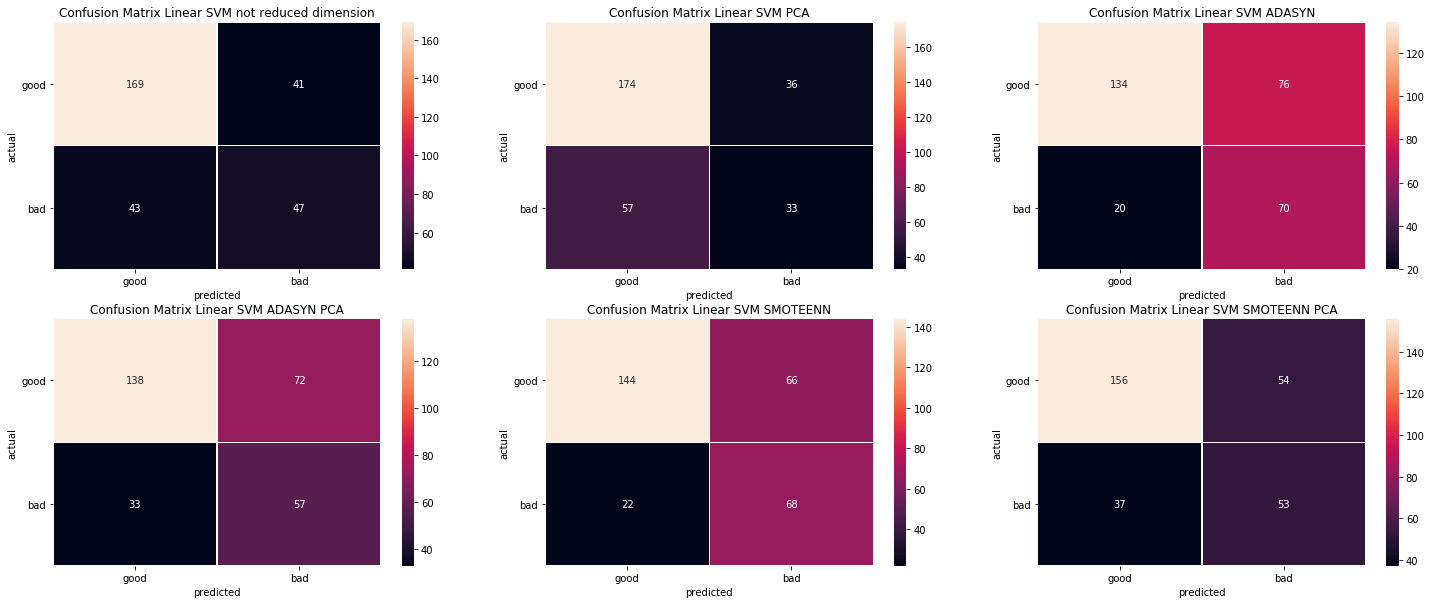

In [49]:
draw_conf_matrices(conf_matrices, conf_matr_titles)

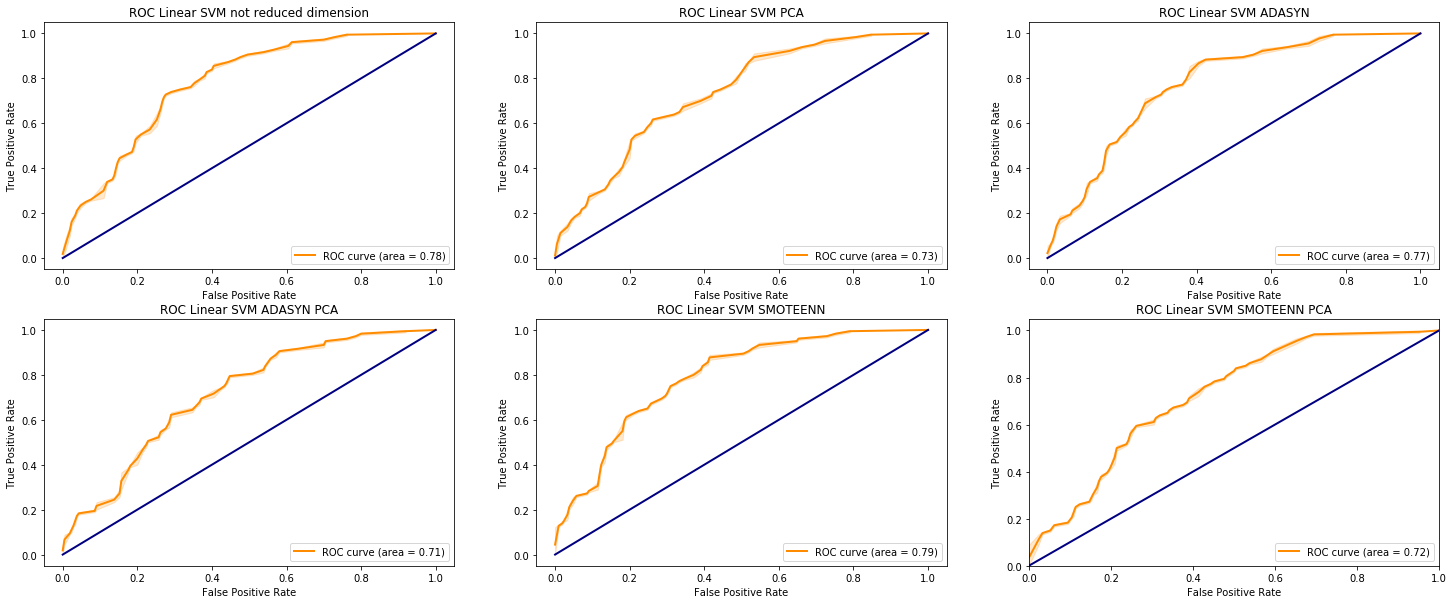

In [50]:
draw_rocs(rocs, roc_aucs, roc_titles)

#### SVM with RBF Kernel

One of the main advantages of SVM is that they can be kernelized. Linear SVMs work by finding the best hyperplane which splits the data, this is also called halfspace. The power of such method is rather restricted, there are problems which are not linearly separable. A simple solution to this problem is to map the input dimension to an higher dimensional space in which we hope the data is linearly separable. In this case we would apply SVM to the data in the new space, also called the feature space.
<figure>
<img src="media/feature_space.png" style="width: 400px;">
    <figcaption><center><i>In this higher dimensional space data is linearly separable. <a href="https://towardsdatascience.com/the-kernel-trick-c98cdbcaeb3f"> Source</a></i></center></figcaption>
</figure>

More formally we can say that this technique consists in $4$ steps:
1. Given a domain set $\mathcal{X}$, choose a mapping $\Phi:\mathcal{X}\to\mathcal{F}$ for some feature space $\mathcal{F}$. This feature space can be any Hilbert space of finite dimension $n$ or infinite dimension.
2. Given a sequence of training examples $S=(x_1, y_1),\dots,(x_m, y_m)$ map the training data to $\hat{S}=(\Phi(x_1),y_1),\dots,(\Phi(x_m),y_m)$
3. Train a linear prediction on the mapped data (can be an SVM but also another algorithm)
4. Perform prediction on the learned hyperplane.

This method has two major problems: computing the mapped data in the feature space can be very computationally expensive. Secondly finding good feature mappings could be difficult and need some prior knowledge. A solution to this problem is to use the kernel trick. With the term <i>kernels</i> we intend inner products in the feature space. So given a domain space $\mathcal{X}$, some feature mapping $\Phi$ in some Hilbert space we define the kernel function $K(\mathbf{x},\mathbf{x'})=\langle\Phi(\mathbf{x}),\Phi(\mathbf{x'})\rangle$. Having defined the kernel means that if we are able to write all the operations that we need to carry out as inner products between the data, then we do not care of finding an ad hoc feature mapping, all we need to do is substiting the inner products with the kernel. This means that we can also use kernels that are related to a mapping to a space with an infinite number of dimension. This is the so called Kernel Trick and permits of solving higly non linear problem in an efficient way.

As we saw in the Linear SVM case, we can rewrite the optimization problem by getting the dual. In this new case all the operations that involve the data is constituted of inner products. This means that SVM can be kernelized. This result is formalized better in the Representer Theorem.

In this section we are going to use a particular Kernel: the Radial Basis Function kernel Let the original data space be $\mathbb{R}$ and consider the mapping $\Phi$, where for each non-negative integer $n$ there exists an element $\Phi(x)_n$ that is equal to: $\frac{1}{\sqrt{n}!}e^{-\frac{x^2}{2}}x^n$, then:
\begin{align*}
\langle\Phi(x),\Phi(x')\rangle &= \sum_{n=0}^{\infty}\left(\frac{1}{\sqrt{n}!}e^{-\frac{x^2}{2}}x^n\right)\left(\frac{1}{\sqrt{n}!}e^{-\frac{(x)'^2}{2}}(x')^n\right)\\
&=e^{-\frac{x^2+(x')^2}{2}}\sum_{n=0}^{\infty}\frac{(xx')^n}{n!}\\
&=e^{-\frac{\|x-x'\|^2}{2}}
\end{align*}

more generally, given a scalar $\sigma>0$ we could define the RBF kernel as:
\begin{equation*}
K(\mathbf{x}, \mathbf{x'})=e^{-\frac{\|\mathbf{x}-\mathbf{x'}\|^2}{2\sigma}}
\end{equation*}

Intuitively the Gaussian kernel sets the inner product in the feature space to be near zero if the two points a far away, viceversa near one if they are close. With $\sigma$ we determine the scale so what do we mean by "close".
In the literature (and also in sklearn) instead of $\sigma$ we rather find the parameter $\gamma=\frac{1}{2\sigma}$. Thus it indicates how far the influence of a single training sample reaches, low values mean far, and high values mean close. $\gamma$ can be seen as the inverse of the radius of influence of samples selected by the model as support vectors.

We will now perform a grid search for:
- $C = 1e-4, 1e-3, 1e-2, 1e-1, 1, 10$
- $\gamma = 1e-3, 1e-2, 1e-1, 1, 10$

In [51]:
params = {
    "kernel" : ["rbf"],
    "C": [1e-4, 1e-3, 1e-2, 1e-1, 1, 10],
    "gamma": [1e-3, 1e-2, 1e-1, 1, 10]
}
classifier = SVC
model_names = ["RBF SVM", "RBF SVM PCA",\
               "RBF SVM ADASYN", "RBF SVM ADASYN PCA",\
               "RBF SVM SMOTEENN", "RBF SVM SMOTEENN PCA"]
conf_matr_titles = ["Confusion Matrix RBF SVM not reduced dimension", "Confusion Matrix RBF SVM PCA",\
                    "Confusion Matrix RBF SVM ADASYN", "Confusion Matrix RBF SVM ADASYN PCA",\
                    "Confusion Matrix RBF SVM SMOTEENN", "Confusion Matrix RBF SVM SMOTEENN PCA"]

roc_titles = ["ROC RBF SVM not reduced dimension", "ROC RBF SVM PCA",\
              "ROC RBF SVM ADASYN", "ROC RBF SVM ADASYN PCA",\
              "ROC RBF SVM SMOTEENN", "ROC RBF SVM SMOTEENN PCA"]

In [52]:
results_df, conf_matrices, rocs, roc_aucs = run_classifier(proba=False)

summary_df = summary_df.append(results_df)

results_df

,model_name,parameters,training_score (f2),f1_test,f2_test,accuracy_test,penalty_default_matrix,penalty_adj_matrix
0,RBF SVM,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}",0.480639,0.588889,0.588889,0.753333,0.740000,0.780000
0,RBF SVM PCA,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}",0.490385,0.590909,0.582960,0.760000,0.746667,0.793333
0,RBF SVM ADASYN,"{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}",0.669994,0.606838,0.704365,0.693333,0.560000,0.420000
0,RBF SVM ADASYN PCA,"{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}",0.681461,0.552301,0.648330,0.643333,0.676667,0.653333
0,RBF SVM SMOTEENN,"{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}",0.594787,0.603175,0.620915,0.750000,0.690000,0.680000
0,RBF SVM SMOTEENN PCA,"{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}",0.574580,0.574257,0.614407,0.713333,0.713333,0.726667


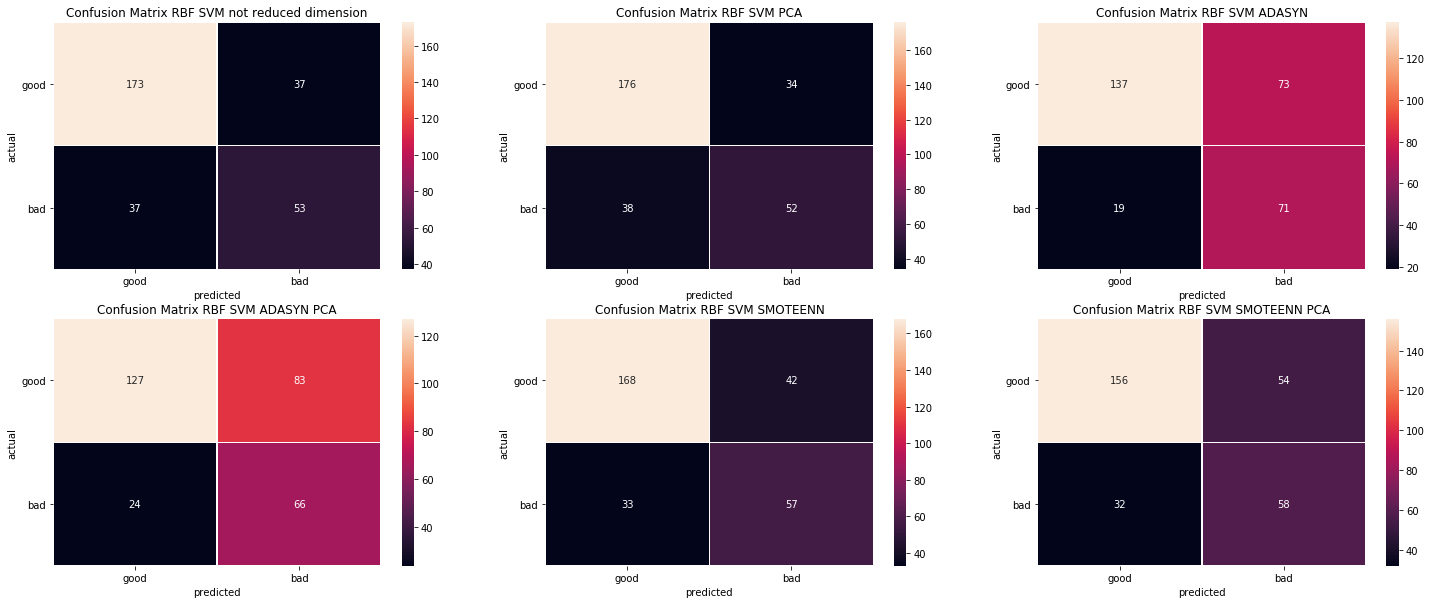

In [53]:
draw_conf_matrices(conf_matrices, conf_matr_titles)

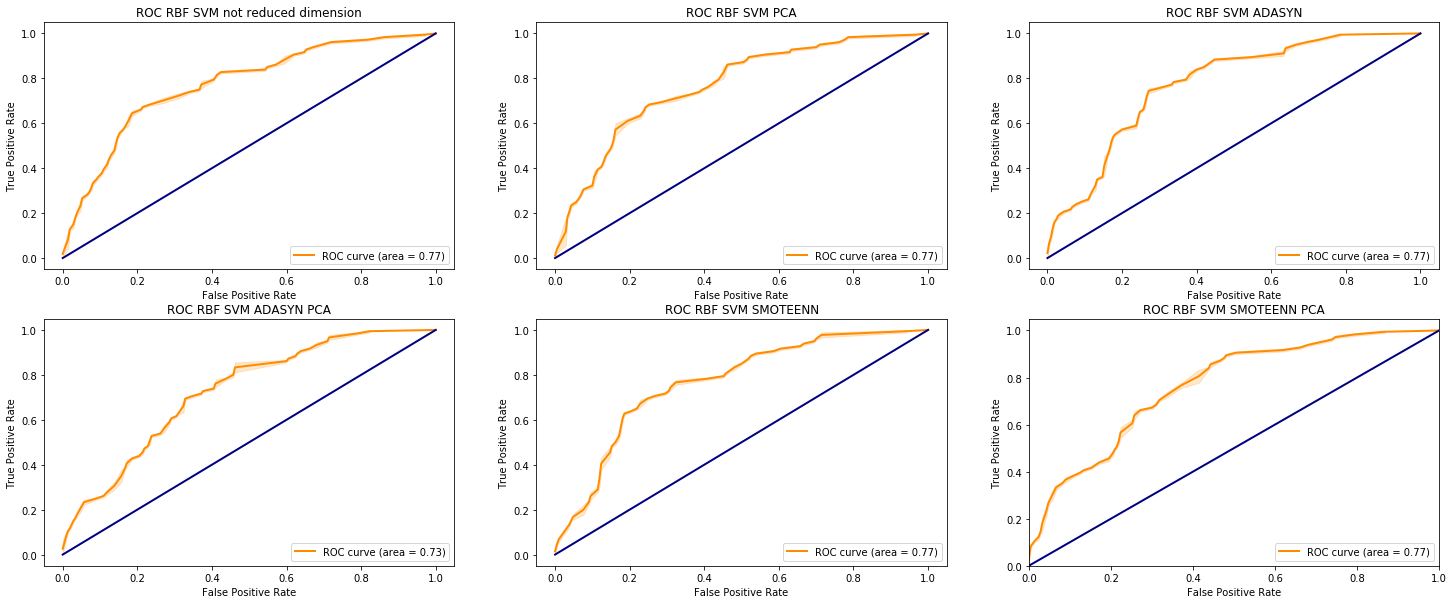

In [54]:
draw_rocs(rocs, roc_aucs, roc_titles)

### Logistic Regression

Logistic Regression can be seen as a particular case of the Generalized Linear Model (GLM). Such model in general has basically three components:

1. A response vector $Y_1,\dots,Y_m$ of indipendent r.v. with a mean $\mu_i=\mathbb{E}(Y_i)$. The data will be the realizations of these random variables $y_1,\dots, y_m$.
2. A linear combinations $\mathbf{\eta}$ of predictors $\mathbf{\beta}$  and data $X$ with values varying with $i=1,\dots,n$: $\eta_i = \sum_j\beta_jx_{i,j}$ or in matricial form $\mathbf{\eta}=X\mathbf{\beta}$.
3. A link function connecting the means $\mu_i$ and the linear combinations $\eta_i$: $g(\mu_i)=\eta_i$

Having defined the GLM in this way we can consider in particular the case in which the response variables are Bernoulli variables with paramenter $p_i$.
\begin{equation*}
Y_i\sim Bernoulli(p_i)
\end{equation*}

We know that: $\mathbb{E}(Y_i)=0(1-p_i)+1(p_i)=p_i$, so now to apply the GLM we only need to define a proper link function $g(\mu_i)$. A simple choice would be to use the identity function, in this way: $p_i=\sum_j\beta_jx_{i,j}$.
This is definitely not a good idea, because it would be like fitting a regression model to solve a classification problem. The values returned by the linear combination of data and predictor would be over an unbounded straight line, but we know that $p_i$ could only assume values between $0$ and $1$. 

We need something else, an intelligent solution could be to use the logit link function, defined as:
\begin{equation*}
logit(p)=\log(\frac{p}{1-p})
\end{equation*}

But why this could be a good choice? Let's start considering the odds function: $\frac{p}{1-p}$. the problem with this function is that it is not symmetrical. We can simply symmetrize it by taking the log, thus getting the log-odds function or logit.
<figure>
<img src="media/350px-Logit.png" style="width: 400px;">
    <figcaption><center><i>The logit function.</i></center></figcaption>
</figure>

The logit function stretches the entire real line to the range $[0, 1]$. We can use it as a link function, thus getting: $logit(p_i)=\sum_j\beta_jx_{i, j}$.

With a little algebra we can simply compute the inverse of the logit: $p_i=\frac{e^{\sum_j\beta_jx_{i, j}}}{1+e^{\sum_j\beta_jx_{i, j}}}$

Lets call this function $\sigma(\sum_j\beta_jx_{i, j})=\frac{1}{1+e^{\sum_j\beta_jx_{i, j}}}$ the <i>sigmoid</i> function, we know then that $1-\sigma(\sum_j\beta_jx_{i, j})=\frac{e^{\sum_j\beta_jx_{i, j}}}{1+e^{\sum_j\beta_jx_{i, j}}}$

So in our classification problem the likelihood that we want to maximize is:
\begin{equation*}
        L(y|X\mathbf{\beta})=\prod_i(1-\sigma(\sum_j\beta_jx_{i, j}))^{y_i}\sigma(\sum_j\beta_jx_{i, j})^{1-y_i}
\end{equation*}
we can as usual take the logarithm, compute the derivative with respect to the $\beta$'s and get:
\begin{equation*}
 \frac{\partial}{\partial\mathbf{\beta_j}}L(\mathbf{\beta})=\dots=\sum_{j}x_{i,j}(y_i-(1-\sigma(\sum_i\beta_ix_{i, j})))
\end{equation*}

The expression we have found is the update rule of the coefficients and is equal to the sample multiplied by the true label minus the prediction of the label; this function has not a close solution, so we can not find a formula to compute the parameters,
but on the other hand it is the derivative of a convex function; so we can optimize it with stochastic gradient descent.

In order to reduce overfitting we can regularize the model by imposing additional constraints on the parameters. For example we can assume $\mathbf{w}_i$ comes from a Gaussian distribution with mean $0$ and variance $\sigma^2_0$ (prior on the parameters), $\sigma^2_0$ is user defined.
In that case we have a prior on the parameter and so:
\begin{equation*}
        \mathbb{P}(y=1, \theta|X)\propto \mathbb{P}(y=1|X;\theta)\mathbb{P}(\theta)
\end{equation*}

So if we take into account this prior will have a posterior which will be the goal of optimization.
So the log likelihood becomes:
\begin{equation*}
        \ln L(y|X;\mathbf{w})=\sum_{i=1}^N\ln(1-\sigma(\sum_j\beta_jx_{i, j}))+(1-y_i)\ln(\sigma(\sum_j\beta_jx_{i, j}))-\sum_j\frac{\mathbf{
        \beta_j^2}}{2\sigma^2_0}
\end{equation*}

In this case we perform a MAP (Maximum A priori Probability) estimate.
The regularization studied is called $L_2$ regularization, we are trying to minimize the sum of square value of the $\beta_i$s. Another regularization tecqnique is $L_1$ regularization which tries to
minimize $|\mathbf{\beta}|$.

In our anaylisis we will perform Logistic Regression by tuning the parameter $C$ which is proportional to the inverse of the variance of the prior $\sigma_0^2$. This parameters tunes the strength of the regularization, like in SVM smaller values imply stronger regularization.

We will now perform a grid search for:
- $C =  1e-3, 1e-2, 1e-1, 1, 10$  

In [55]:
params = {
    "C": [1e-3, 1e-2, 1e-1, 1, 10]
}
classifier = LogisticRegression
model_names = ["Logistic Regression", "Logistic Regression PCA",\
               "Logistic Regression ADASYN", "Logistic Regression ADASYN PCA",\
               "Logistic Regression SMOTEENN", "Logistic Regression SMOTEENN PCA"]
conf_matr_titles = ["Confusion Matrix Logistic Regression not reduced dimension", "Confusion Matrix Logistic Regression PCA",\
               "Confusion Matrix Logistic Regression ADASYN", "Confusion Matrix Logistic Regression ADASYN PCA",\
                   "Confusion Matrix Logistic Regression SMOTEENN", "Confusion Matrix Logistic Regression SMOTEENN PCA"]

roc_titles = ["ROC Logistic Regression not reduced dimension", "ROC Logistic Regression not reduced dimension PCA",\
              "ROC Logistic Regression ADASYN", "ROC Logistic Regression ADASYN PCA",\
              "ROC Logistic Regression SMOTEENN", "ROC Logistic Regression SMOTEENN PCA"]


In [56]:
results_df, conf_matrices, rocs, roc_aucs = run_classifier(proba=True)

summary_df = summary_df.append(results_df)

results_df

,model_name,parameters,training_score (f2),f1_test,f2_test,accuracy_test,penalty_default_matrix,penalty_adj_matrix
0,Logistic Regression,{'C': 1},0.496659,0.556818,0.549327,0.740000,0.806667,0.913333
0,Logistic Regression PCA,{'C': 10},0.376096,0.392157,0.354610,0.690000,1.110000,1.520000
0,Logistic Regression ADASYN,{'C': 10},0.638665,0.610619,0.695565,0.706667,0.573333,0.446667
0,Logistic Regression ADASYN PCA,{'C': 10},0.647087,0.537736,0.591286,0.673333,0.766667,0.833333
0,Logistic Regression SMOTEENN,{'C': 0.1},0.559169,0.582524,0.630252,0.713333,0.686667,0.673333
0,Logistic Regression SMOTEENN PCA,{'C': 0.1},0.567341,0.486772,0.501089,0.676667,0.910000,1.120000


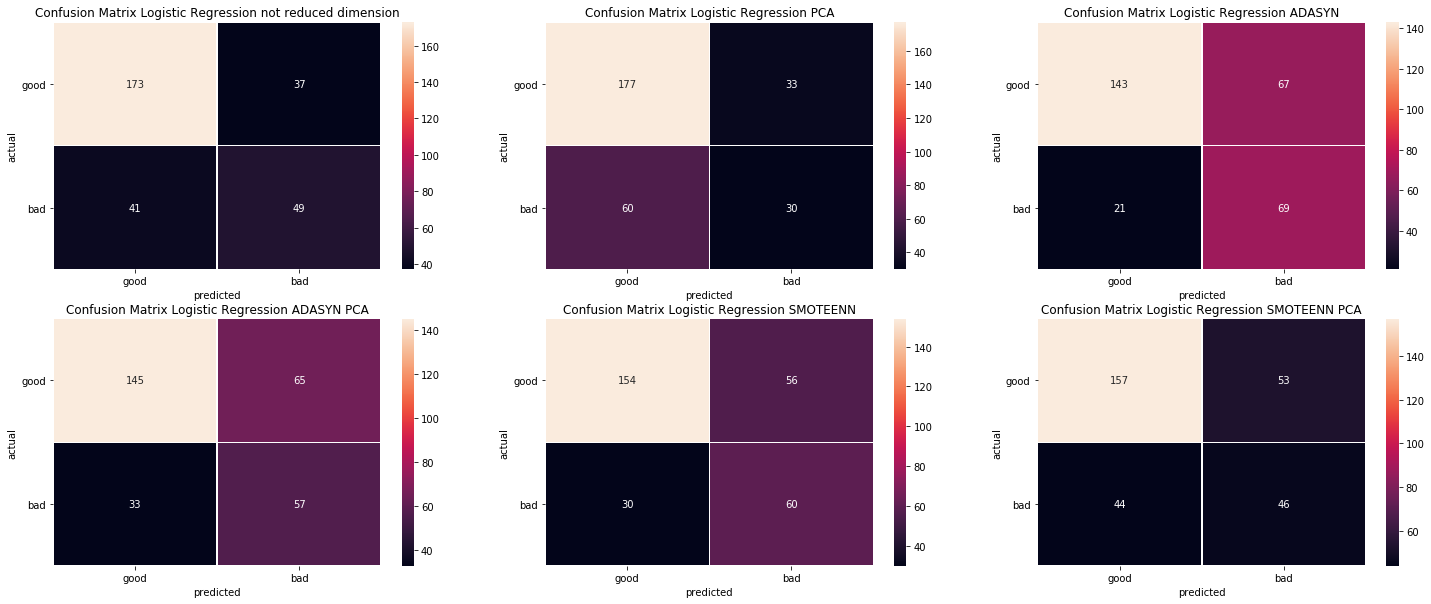

In [57]:
draw_conf_matrices(conf_matrices, conf_matr_titles)

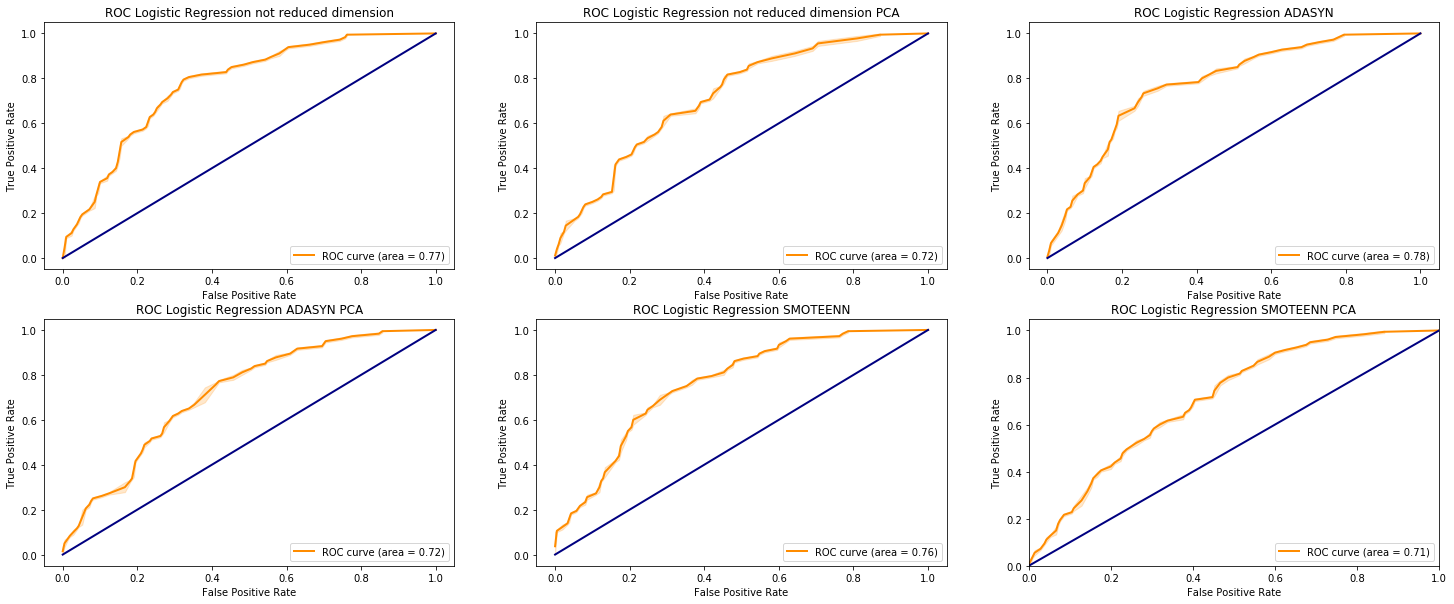

In [58]:
draw_rocs(rocs, roc_aucs, roc_titles)

### Decision Trees

Decision trees are algorithms that use a tree-like structure to make predictions. In particolar each internal node of the tree performs a test on a predictor (for example attribute $foreign=yes$) while each branch represents the outcome of the test. Each leaf node represent the outcome of the classification (label). Then the various paths from the root to the leaves are decision rules on the data.

<figure>
<img src="media/tree_credit.png" style="width: 400px;">
    <figcaption><center><i>Example of decision tree for a generic credit risk analysis. <a href="https://medium.com/@ryotennis0503/what-is-decision-tree-345d8d27c350">Source</a></i></center></figcaption>
</figure>

One great advantage of Decision Trees is that they are very interpretable, furthermore decision trees can naturally handle categorical variables. Of course the decision tests can also be generalized to continuous data. This is done basically in two ways:

- Binary decision: split according to $A<v$ or $A>v$ where $A$ is a continuous attribute and $v$ is an arbitrary number.
- Discretization: form and ordinal categorical attribute from a continuous one. This can be done in various ways, for example by equal interval bucketing, equal frequency bucketing (percentiles) or by clustering. The discretization can be done at the beginning of the tree or at each split. So at each step, we sort the observations by the continuous attribute and we discretize according to the threshold defined (C4.5 and CART use this tecnique).

In general a split can be of two types:
- Binary: only two branches as result of a test.
- Multiway: more than two branches as result of a test.

In order to build a decision tree we need an algorithm which chooses the best possible rules. Unfortunately find an optimal decision tree is an NP-Hard problem, so it is computationally intractable. Nevertheless various algorithms have emerged during the years for the tree-building process, these are greedy algorithms, this means that they build the tree by considering the best possible split <i>at each step</i>. The resulting tree may not be optimal, but usually provides good results.

But how can we measure if a split is better than another? How can we find the best possible rule at each step?
The main idea is that splits in which there is  <i>homogeneity</i> between classes should be preferred. At each node of the tree we want to have the class distribution as homogeneus as possible, this means that most of the elements should belong to one class and only a little fraction of samples to the other class. Having said so we can see that the maximum possible homogenity is when in a split there are only samples for one class and the other is not represented. Viceversa the lowest possible value of homogeneity is when the classes are balanced in the split. 
Thus homogeneity in the context of decision tree can be seen as a measure of node purity: the goal of the decision tree is to choose among all possible splits at each step the one which minimizes the node impurity, or maximizes the homogeneity.

There are several indexes for measuring homogeneity, some of the most important are:

- **GINI Index**: Defined as \begin{equation*}GINI(t)=1-\sum_i[p(i|t)]^2\end{equation*} where $p(i|t)$ is the relative frequency of class $i$ at the node $t$ of the tree. The GINI index assume it's maximums value $\frac{1}{\text{num classes}}$ when the classes are equally represented, this means that there is an high impurity at the node. Viceversa it assumes its minimum values $0$ when all elements belong to one class and the others are not represented. We can define the quality of a split using the GINI index in the case of a multiway splitting of a parent node $p$ with $k$ partitions by computing the impurity measure of the particular split: \begin{equation*}GINI_{split}=\sum_{i=1}^{k}\frac{n_i}{n_p}GINI(i)\end{equation*}. Where $n_i$ is the number of records at child $i$, $n_p$ is the number of record at the parent node $p$ and $GINI(i)$ is the GINI index at the child node $i$. When building the tree the split which at each step has the minimum value of $GINI_{split}$ is choosen.This is the strategy used in the CART algorithm (also used in SLIQ, SPRINT). 

- **Entropy Index**: Defined as \begin{equation*}Entropy(t)=\sum_i-p(i|t)\log_2p(i|t)\end{equation*}. In this case too the maximum for entropy is for equally distributed classes at split $t$ and Entropy assumes value $log_2(\text{num_classes})$ implying and high level of impurity. The minimum is at $0$ when only one class is represented and implies a low level of impurity. The algorithms that use this type of index usually want to perform the splits by looking at the gain in information that each splits provides, thus they look at an index derived from Entropy called Information Gain defined in the case of multiway splitting of a parent node $p$ into $k$ child nodes as: \begin{equation*}GAIN_{split}=Entropy(p)-\sum_{i=1}^{k}\frac{n_i}{n_p}Entropy(i)\end{equation*}. At each node, the split which maximizes the IG index is choosen. This is the strategy adopted by ID3, C4.5. Information gain has a problem: it tends to prefer splits yielding a smaller number of partitions, each small, but pure. To overcome this problem another measure has been proposed, Gain Ratio: \begin{equation*}GainRATIO_{split}=\frac{GAIN_{split}}{SplitINFO}\end{equation*}, where $SplitINFO$ is defined as: $SplitINFO=-\sum_{i=1}^k\frac{n_i}{n_p}\log(\frac{n_i}{n_p})$. The idea is to adjust the gain according to the Entropy of the partitioning SplitINFO. Higher entropy partitioning (high number of small partitions) is penalized. This strategy is used in C4.5.

In general the tree building process continues until all samples have been classified correctly(impurity is minimized). This means that the accuracy computed by evaluating the algorithm on the training set is $100\%$. This of course is not true for the test set.
<figure>
<img src="media/tree_classification.gif" style="width: 600px;">
    <figcaption><center><i>How the classification is performed for decision trees. <a href="http://www.r2d3.us/visual-intro-to-machine-learning-part-1/">Source</a></i></center></figcaption>
</figure>

There are different algorithms for solving decision trees, for example ID3, C4.5, CART and each one uses different impurity measures, different way for performing the splits and so on. In our analysis we will use an optimized version of the CART algorithm which uses the GINI index as impurity measure (ID3 is similar to CART but uses Entropy instead of GINI, and support only classification while CART can also be used for regression). For a complete list of the difference betweens the various algorithms see [3].

One of the main problems of these algorithms is that the returned tree can be very big and complex and this can lead to overfitting. There are various solutions, for example we could limit the depth of the three. This can lead to leaf nodes with a certain level of residual impurity. In this case a majority vote in the leaf is taken to output a classification model.
Another strategy could be to prune the tree after the tree is built. The hope is that by eliminating some sub-branches or substituting them with leaves the increase in the training error will be limited and the true risk of the pruned tree will be smaller. The pruning process usually is performed in a bottom up approach: starting from the leaves the model is modified in order to substitute each node with a leaf or with one of its subtrees. At each step the pruned tree which optimizes the validation score or the $k$-Fold cross validation score is kept. The process continues for all the nodes.

There is also another method we can try: random forests. This tecnique will be analyzed in the next section.

We will now fit a Decision Tree classifier for various hyperparameters. In particular we will tune the maximum depth of the tree (in order to not overfit we could decide to stop earlier and assign the label in the leaf to the majority class), the minum number of samples needed for performing a split on an internal node and the minum number of samples required to be a leaf node.

We will now perform a grid search for:
- $\text{max_dept} = \text{None}, 4, 6, 8, 10$
- $\text{min samples split} = 2, 0.2\%, 0.4\%$
- $\text{min samples leaf} = 1, 0.2\%$

In [59]:
params = {
    "max_depth": [None, 4, 6, 8, 10],
    "min_samples_split": [2, 0.2, 0.4],
    "min_samples_leaf": [1, 0.2]
}
classifier = DecisionTreeClassifier
model_names = ["Decision Tree", "Decision Tree PCA",\
               "Decision Tree ADASYN", "Decision Tree ADASYN PCA",\
               "Decision Tree SMOTEENN", "Decision Tree SMOTEENN PCA"]
conf_matr_titles = ["Confusion Matrix Decision Tree not reduced dimension", "Confusion Matrix Decision Tree PCA",\
                    "Confusion Matrix Decision Tree ADASYN", "Confusion Matrix Decision Tree ADASYN PCA",\
                    "Confusion Matrix Decision Tree SMOTEENN", "Confusion Matrix Decision Tree SMOTEENN PCA"]
roc_titles = ["ROC Decision Tree not reduced dimension", "ROC Decision Tree PCA",\
              "ROC Decision Tree ADASYN", "ROC Decision Tree ADASYN PCA",\
              "ROC Decision Tree SMOTEENN", "ROC Decision Tree SMOTEENN PCA"]

In [60]:
results_df, conf_matrices, rocs, roc_aucs = run_classifier(proba=True)

summary_df = summary_df.append(results_df)

results_df

,model_name,parameters,training_score (f2),f1_test,f2_test,accuracy_test,penalty_default_matrix,penalty_adj_matrix
0,Decision Tree,"{'max_depth': 4, 'min_samples_leaf': 1, 'min_s...",0.534569,0.453988,0.427252,0.703333,1.003333,1.306667
0,Decision Tree PCA,"{'max_depth': 6, 'min_samples_leaf': 1, 'min_s...",0.448647,0.449438,0.446429,0.673333,0.993333,1.286667
0,Decision Tree ADASYN,"{'max_depth': 4, 'min_samples_leaf': 1, 'min_s...",0.615558,0.517073,0.557895,0.670000,0.823333,0.946667
0,Decision Tree ADASYN PCA,"{'max_depth': 6, 'min_samples_leaf': 1, 'min_s...",0.565914,0.421569,0.453586,0.606667,1.020000,1.340000
0,Decision Tree SMOTEENN,"{'max_depth': 10, 'min_samples_leaf': 0.2, 'mi...",0.582833,0.510000,0.542553,0.673333,0.846667,0.993333
0,Decision Tree SMOTEENN PCA,"{'max_depth': 4, 'min_samples_leaf': 0.2, 'min...",0.521907,0.407643,0.374707,0.690000,1.083333,1.466667


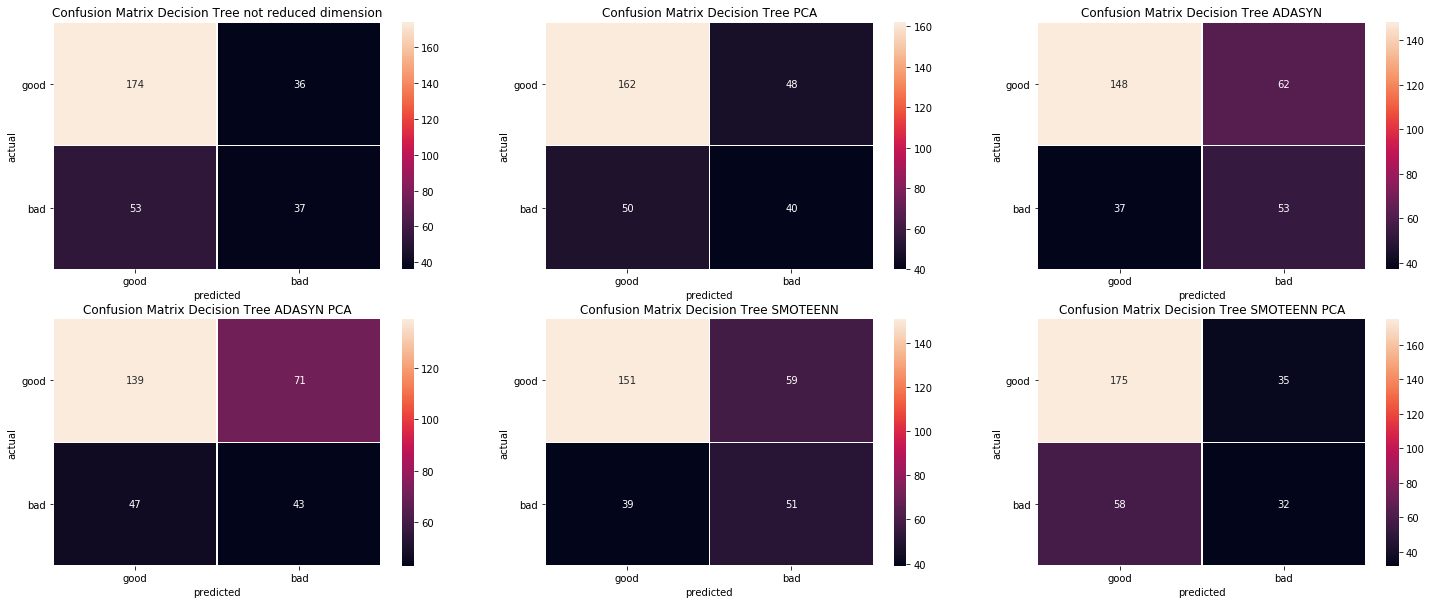

In [61]:
draw_conf_matrices(conf_matrices, conf_matr_titles)

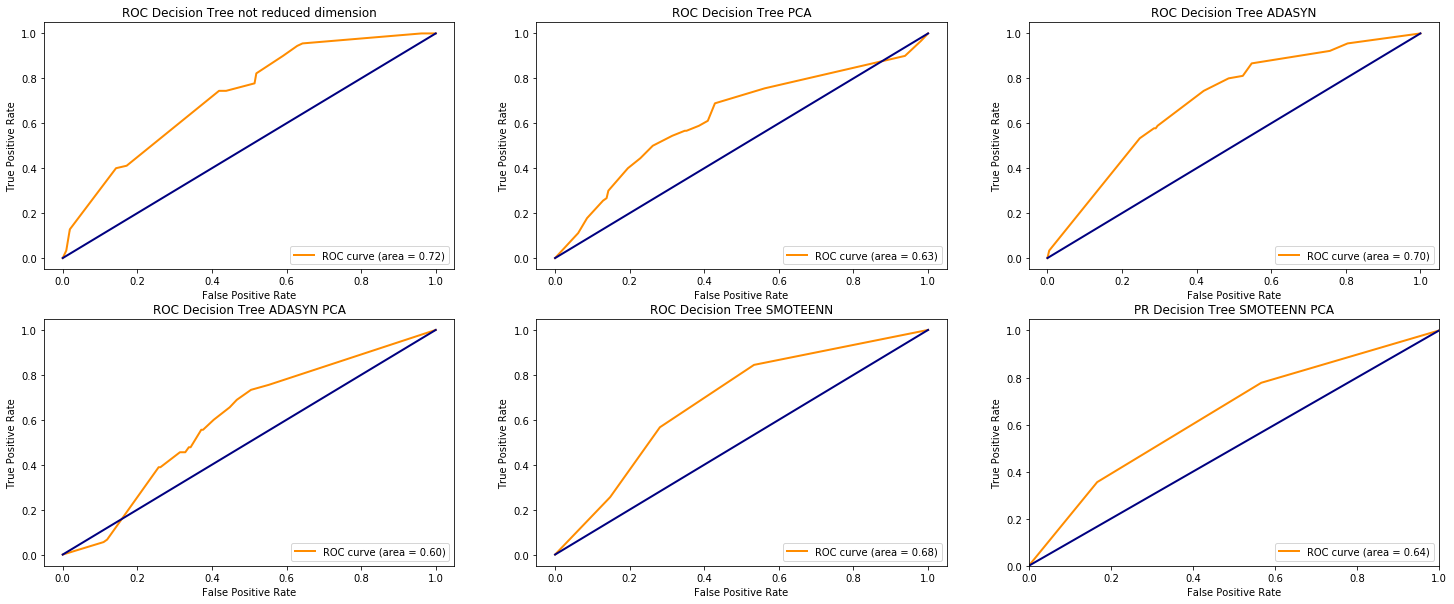

In [62]:
draw_rocs(rocs, roc_aucs, roc_titles)

### Random Forests

Random forests is an example of an ensemble learning method in which different machine learning models are combined in order to get a better predictive performance. So random forests work by building $B$ different decision trees $f_B$ and making decisions by taking majority voting.
The term <i>random</i> in random forests is related to two key concepts:

- A random sample (with replacement) of the training set is used for building each tree. This tecnique is called bootstrap: all of the $B$ decision trees in the forest are fitted using a bootstrapped set of the original training set.
- At each splitting step not all the features of the dataset are considered, but only a random sample of them. The number of features selected $d$ can vary and it is an hyperparameter. The most common choice is to use $d=\sqrt{p})$, where $p$ is the original number of features. In the particular case in which $d=p$ (we are using all the features at each step) the tecnique is not called anymore random forests but bagging. The advantage of using random forests over bagging is that using less features at each step will help to decorrelate the various different trees in the forest.

We will now fit a Random Forest Classifier performing a grid search for:
- $\text{max depth} = \text{None}, 3, 5, 7, 10$
- $\text{number of trees} = 3, 5, 10, 25, 50$
- $\text{number of features to consider at each split} = 4, 7, 15, 20, \sqrt{p}$

In [63]:
params = {"max_depth": [3,5, 7, 10,None],
          "n_estimators":[3,5,10,25,50],
          "max_features": [4,7,15,20, "auto"]}
classifier = RandomForestClassifier
model_names = ["Random Forest", "Random Forest PCA",\
               "Random Forest ADASYN", "Random Forest ADASYN PCA",\
               "Random Forest SMOTEENN", "Random Forest SMOTEENN PCA"]
conf_matr_titles = ["Confusion Matrix Random Forest not reduced dimension", "Confusion Matrix Random Forest PCA",\
                    "Confusion Matrix Random Forest ADASYN", "Confusion Matrix Random Forest ADASYN PCA",\
                    "Confusion Matrix Random Forest SMOTEENN", "Confusion Matrix Random Forest SMOTEENN PCA"]
roc_titles = ["ROC Random Forest not reduced dimension", "ROC Random Forest PCA",\
              "ROC Random Forest ADASYN", "ROC Random Forest ADASYN PCA",\
              "ROC Random Forest SMOTEENN", "ROC Random Forest SMOTEENN PCA"]

In [64]:
results_df, conf_matrices, rocs, roc_aucs = run_classifier(proba=True)

summary_df = summary_df.append(results_df)

results_df

,model_name,parameters,training_score (f2),f1_test,f2_test,accuracy_test,penalty_default_matrix,penalty_adj_matrix
0,Random Forest,"{'max_depth': None, 'max_features': 20, 'n_est...",0.501244,0.444444,0.444444,0.666667,1.000000,1.300000
0,Random Forest PCA,"{'max_depth': None, 'max_features': 'auto', 'n...",0.440928,0.407407,0.381944,0.680000,1.080000,1.460000
0,Random Forest ADASYN,"{'max_depth': 3, 'max_features': 20, 'n_estima...",0.658651,0.582278,0.680473,0.670000,0.610000,0.520000
0,Random Forest ADASYN PCA,"{'max_depth': 3, 'max_features': 20, 'n_estima...",0.602382,0.564315,0.665362,0.650000,0.643333,0.586667
0,Random Forest SMOTEENN,"{'max_depth': 3, 'max_features': 20, 'n_estima...",0.594765,0.536797,0.618762,0.643333,0.730000,0.760000
0,Random Forest SMOTEENN PCA,"{'max_depth': 5, 'max_features': 15, 'n_estima...",0.524075,0.451613,0.460526,0.660000,0.980000,1.260000


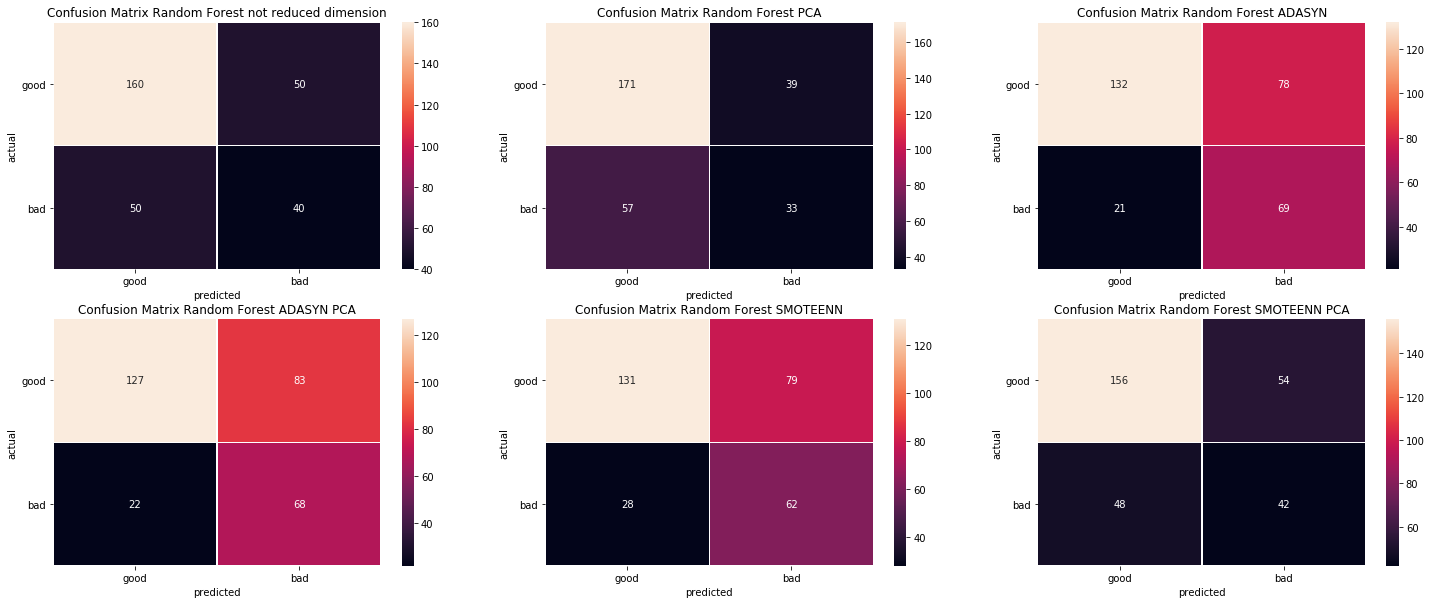

In [65]:
draw_conf_matrices(conf_matrices, conf_matr_titles)

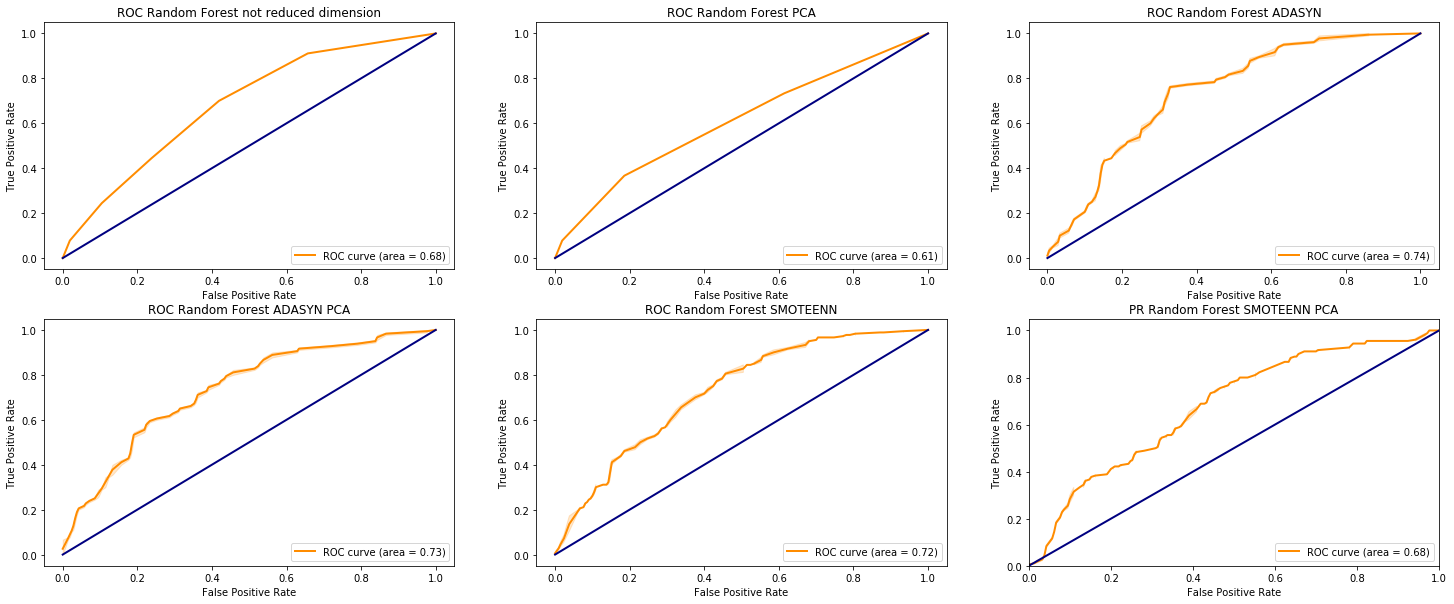

In [66]:
draw_rocs(rocs, roc_aucs, roc_titles)

## Conclusions

We can now see the overall performances of the algorithms on the fitted dataset.

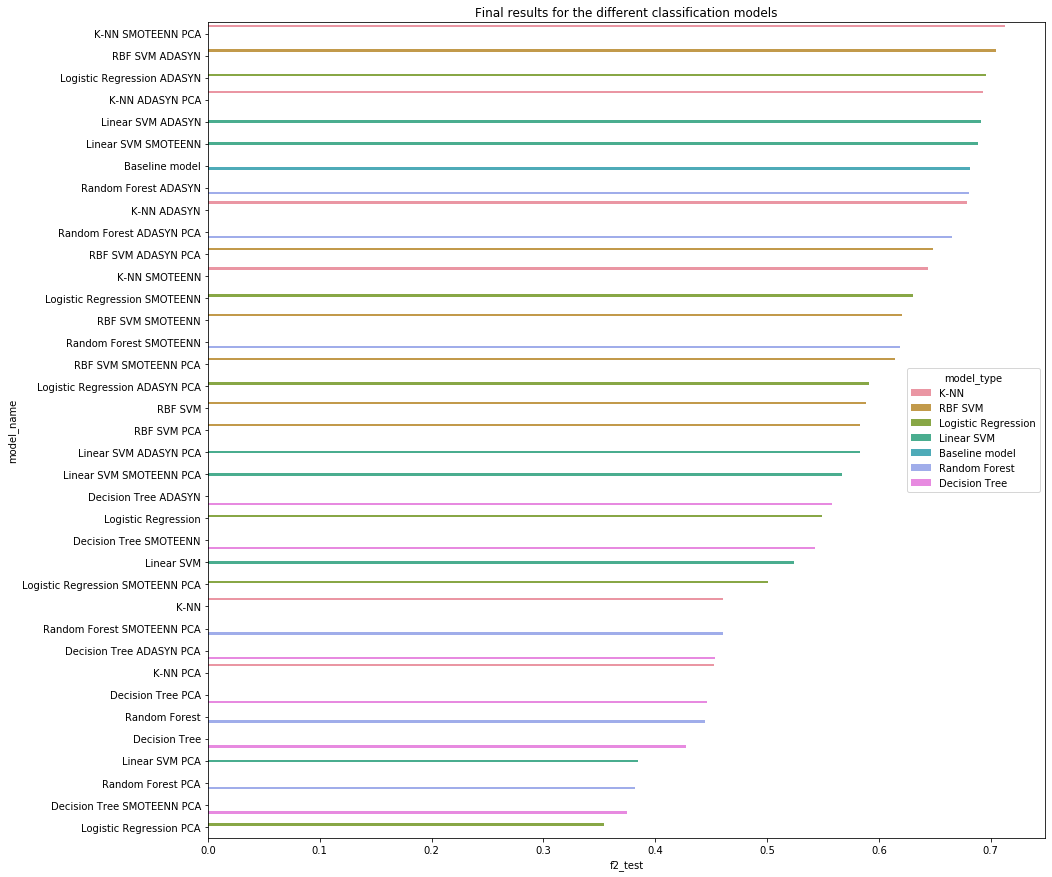

In [67]:
summary_df = summary_df.reset_index(drop=True)
f2_df = summary_df[["f2_test", "model_name"]].copy()
f2_df.loc[0, "model_type"] = "Baseline model"
f2_df.loc[1:len(model_names)+1, "model_type"] = "K-NN"
f2_df.loc[len(model_names)+1:2*len(model_names)+1, "model_type"] = "Linear SVM"
f2_df.loc[2*len(model_names)+1:3*len(model_names)+1, "model_type"] = "RBF SVM"
f2_df.loc[3*len(model_names)+1:4*len(model_names)+1, "model_type"] = "Logistic Regression"
f2_df.loc[4*len(model_names)+1:5*len(model_names)+1, "model_type"] = "Decision Tree"
f2_df.loc[5*len(model_names)+1:6*len(model_names)+1, "model_type"] = "Random Forest"

f2_df = f2_df.sort_values(by=["f2_test"], ascending=False)

fig, ax = plt.subplots(figsize=(15, 15))

ax = sns.barplot(y=f2_df["model_name"], x=f2_df["f2_test"], hue=f2_df["model_type"])
ax.set_title("Final results for the different classification models")
plt.show()

In [68]:
summary_df

,model_name,parameters,training_score (f2),f1_test,f2_test,accuracy_test,penalty_default_matrix,penalty_adj_matrix
0,Baseline model,N/A,0.681818,0.461538,0.681818,0.300000,0.700000,0.700000
1,K-NN,{'n_neighbors': 1},0.434267,0.468571,0.460674,0.690000,0.963333,1.226667
2,K-NN PCA,{'n_neighbors': 1},0.441170,0.448087,0.452539,0.663333,0.990000,1.280000
3,K-NN ADASYN,{'n_neighbors': 13},0.699003,0.544776,0.678439,0.593333,0.633333,0.566667
4,K-NN ADASYN PCA,{'n_neighbors': 13},0.677702,0.553506,0.693161,0.596667,0.603333,0.506667
5,K-NN SMOTEENN,{'n_neighbors': 13},0.670057,0.527132,0.643939,0.593333,0.700000,0.700000
6,K-NN SMOTEENN PCA,{'n_neighbors': 13},0.639863,0.585938,0.712928,0.646667,0.553333,0.406667
7,Linear SVM,"{'C': 0.001, 'max_iter': 30000}",0.505589,0.528090,0.524554,0.720000,0.853333,1.006667
8,Linear SVM PCA,"{'C': 0.001, 'max_iter': 30000}",0.376374,0.415094,0.384615,0.690000,1.070000,1.440000
9,Linear SVM ADASYN,"{'C': 0.001, 'max_iter': 30000}",0.668240,0.593220,0.691700,0.680000,0.586667,0.473333


### References

<div class="cite2c-biblio"></div>

- [1] https://pubmed.ncbi.nlm.nih.gov/11227840/ Use of PCA for dummy encoded data
- [2] http://staskolenikov.net/talks/Gustavo-Stas-PCA-generic.pdf Analysis of PCA for categorical data
- [3] https://bayesian-intelligence.com/publications/TR2010_1_zonneveldt_korb_nicholson_bn_class_credit_data.pdf Use of different penalty matrices
- [4] https://dl.acm.org/doi/10.1145/1007730.1007735 On the use of SMOTEENN with ENN applied both to the majority and minority class